<a href="https://colab.research.google.com/github/tu55287/FSP-prototypes/blob/main/Prototype_Learning_for_Frame_Semantic_Parsing_with_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prototype Learning for Frame Semantic Parsing with Transformers**

This notebook contains the full implementation of experiments described in the master’s thesis “Prototype Learning for Frame Semantic Parsing with Transformers” by Chao Yu, Master of Artificial Intelligence, KU Leuven (2025). To successfully run the code, it is recommended to use Google Colab with GPU enabled and to mount Google Drive for file management. The datasets required for the OpenSesame baseline must be downloaded manually from their official GitHub repository and stored locally. The notebook is designed so that the cells can generally be executed in sequence.

In [ ]:


# @title 🧠 encode_target_spans_batch encode_sentences_batch
def encode_target_spans_batch(sentences, target_spans_list, tokenizer, model,
                             batch_size=32, max_length=512, train_mode=False, verbose=False):
    """
    Batch encoding of target spans, using precise positioning + mean pooling, optimised for GPU performance
    """

    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"🔄 Batch encoding {len(sentences)} target spans (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding target spans", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    # Check whether tokenizer supports offset_mapping
    supports_offset_mapping = hasattr(tokenizer, 'is_fast') and tokenizer.is_fast

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]
        batch_spans = target_spans_list[i:i + batch_size]

        # Preprocess spans, normalising them into position coordinates
        processed_spans = []
        for j, spans in enumerate(batch_spans):
            sentence = batch_sentences[j]

            # Handle different span formats
            if isinstance(spans, str):
                start = sentence.find(spans.strip())
                if start != -1:
                    processed_spans.append([(start, start + len(spans.strip()))])
                else:
                    processed_spans.append([])
            elif isinstance(spans, list):
                if spans and isinstance(spans[0], str):
                    positions = []
                    for span_text in spans:
                        start = sentence.find(span_text.strip())
                        if start != -1:
                            positions.append((start, start + len(span_text.strip())))
                    processed_spans.append(positions)
                else:
                    normalized = []
                    for span in spans:
                        if isinstance(span, (list, tuple)) and len(span) == 2:
                            normalized.append((int(span[0]), int(span[1])))
                    processed_spans.append(normalized)
            else:
                processed_spans.append([])

        # Batch tokenisation – decide whether to use offset_mapping based on support
        if supports_offset_mapping:
            try:
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_offsets_mapping=True,
                    return_attention_mask=True
                )
                use_offset_mapping = True
            except:
                # Fallback if offset mapping fails
                encoding = tokenizer(
                    batch_sentences,
                    return_tensors='pt',
                    truncation=True,
                    max_length=max_length,
                    padding=True,
                    return_attention_mask=True
                )
                use_offset_mapping = False
        else:
            encoding = tokenizer(
                batch_sentences,
                return_tensors='pt',
                truncation=True,
                max_length=max_length,
                padding=True,
                return_attention_mask=True
            )
            use_offset_mapping = False

        # Move directly to device to avoid repeated conversion
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        if use_offset_mapping:
            offset_mappings = encoding['offset_mapping']  # Keep on CPU

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state

            batch_embeddings = []

            for j in range(len(batch_sentences)):
                target_spans = processed_spans[j]

                if use_offset_mapping:
                    # Accurate matching via offset mapping
                    offset_mapping = offset_mappings[j]
                    selected_indices = []
                    for start_char, end_char in target_spans:
                        for token_idx, (token_start, token_end) in enumerate(offset_mapping):
                            if token_start == 0 and token_end == 0:
                                continue
                            if token_start < end_char and token_end > start_char:
                                selected_indices.append(token_idx)

                    selected_indices = list(set(selected_indices))
                else:
                    # Fallback: approximate method based on linear mapping
                    selected_indices = []
                    if target_spans:
                        sentence_len = len(batch_sentences[j])
                        seq_len = attention_mask[j].sum().item() - 2  # Subtract [CLS] and [SEP]

                        for start_char, end_char in target_spans:
                            start_token = int((start_char / sentence_len) * seq_len) + 1
                            end_token = int((end_char / sentence_len) * seq_len) + 1
                            start_token = max(1, min(start_token, seq_len))
                            end_token = max(start_token, min(end_token, seq_len))
                            selected_indices.extend(range(start_token, end_token + 1))

                        selected_indices = list(set(selected_indices))

                if selected_indices:
                    selected_hidden = last_hidden[j, selected_indices, :]
                    embedding = selected_hidden.mean(dim=0)
                else:
                    valid_mask = attention_mask[j].bool()
                    valid_hidden = last_hidden[j][valid_mask]
                    embedding = valid_hidden[1:-1].mean(dim=0) if len(valid_hidden) > 2 else valid_hidden.mean(dim=0)

                batch_embeddings.append(embedding)

            # Stack on GPU and convert at once
            batch_embeddings_tensor = torch.stack(batch_embeddings)
            all_embeddings.append(batch_embeddings_tensor)

    # Concatenate and return
    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


def encode_sentences_batch(sentences, tokenizer, model, batch_size=32,
                          max_length=512, train_mode=False, verbose=False):
    """
    Batch sentence encoding function, using CLS token, optimised for GPU performance
    """
    model.eval()
    device = next(model.parameters()).device  # Check device only once
    all_embeddings = []

    if verbose:
        print(f"🔄 Batch encoding {len(sentences)} sentences (batch_size={batch_size})...")

    # Decide whether to show progress bar based on verbose parameter
    iterator = range(0, len(sentences), batch_size)
    if verbose:
        from tqdm import tqdm
        iterator = tqdm(iterator, desc="Encoding sentences", total=len(sentences)//batch_size + (1 if len(sentences)%batch_size else 0))

    for i in iterator:
        batch_sentences = sentences[i:i + batch_size]

        # Batch tokenisation
        encoding = tokenizer(
            batch_sentences,
            return_tensors='pt',
            truncation=True,
            max_length=max_length,
            padding=True,
            return_attention_mask=True
        )

        # Move directly to device using non_blocking optimisation
        input_ids = encoding['input_ids'].to(device, non_blocking=True)
        attention_mask = encoding['attention_mask'].to(device, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings)

    final_embeddings = torch.cat(all_embeddings, dim=0)
    return final_embeddings


In [ ]:
# @title 🧠 extract_frame_prototypes

def extract_frame_prototypes(model, tokenizer, df, batch_size=64):
    """
    Extract frame prototypes using mean pooling

    Args:
        model: Trained Transformer model
        tokenizer: HuggingFace tokenizer
        df: DataFrame containing training samples
        batch_size: Batch size

    Returns:
        dict: Mapping from frame name to prototype vector
    """

    model.eval()
    frame_prototypes = {}
    frame_groups = df.groupby('frame_name')

    for frame_name, frame_df in tqdm(frame_groups, desc="Extracting frame prototypes"):
        sentences = frame_df['sentence'].tolist()
        target_spans_list = frame_df['target_spans'].tolist()

        # Batch encode target spans
        target_embeddings = encode_target_spans_batch(
            sentences, target_spans_list, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )

        # Compute mean prototype
        prototype = target_embeddings.mean(dim=0).cpu().numpy()
        frame_prototypes[frame_name] = prototype

    print(f"✅ Extracted {len(frame_prototypes)} frame prototypes")
    return frame_prototypes



In [ ]:
# @title 🧠 evaluate_target_known evaluate_target_unknown

def evaluate_target_known(model, tokenizer, test_df, frame_prototypes=None,
                         train_df=None, top_n=3, batch_size=64):
    """
    Target-known evaluation: given the target span, evaluate frame classification accuracy

    Args:
        model: Trained model
        tokenizer: HuggingFace tokenizer
        test_df: Test dataset
        frame_prototypes: Precomputed frame prototype dictionary (optional)
        train_df: Training dataset (used to compute prototypes on the fly if not provided)
        top_n: Number of top predictions to consider
        batch_size: Batch size

    Returns:
        dict: Evaluation results dictionary
    """

    model.eval()

    # Get or compute frame prototypes
    if frame_prototypes is None:
        if train_df is None:
            raise ValueError("Must provide either frame_prototypes or train_df")
        print("🔄 Computing frame prototypes on the fly...")
        frame_prototypes = extract_frame_prototypes(model, tokenizer, train_df, batch_size)
    else:
        print("📊 Using existing frame prototypes")

    # Prepare prototype matrix
    prototype_frames = list(frame_prototypes.keys())
    prototype_vectors = [frame_prototypes[frame] for frame in prototype_frames]
    prototype_matrix = np.array(prototype_vectors)

    print(f"🎯 Evaluating {len(test_df)} test samples, {len(prototype_frames)} frame prototypes")

    # Batch encode target spans of the test data
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # Filter out invalid spans
    valid_indices = []
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 Valid test samples: {len(valid_indices)}/{len(test_df)}")

    # Batch encode target embeddings
    test_embeddings = encode_target_spans_batch(
        valid_sentences, valid_spans, tokenizer, model,
        batch_size=batch_size, train_mode=False
    ).cpu().numpy()

    # Compute cosine similarity
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    # Evaluation results
    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        # Get top-N predictions
        scores = similarities[i]
        top_indices = np.argsort(scores)[-top_n:][::-1]  # Sort in descending order
        top_preds = [prototype_frames[idx] for idx in top_indices]

        y_true.append(gold_frame)
        y_pred_top1.append(top_preds[0])

        if gold_frame == top_preds[0]:
            correct_top1 += 1
        if gold_frame in top_preds:
            correct_top3 += 1

    # Compute various metrics
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(prototype_frames)
    }

    # Print results
    print(f"\n✅ Target-known evaluation results (Cosine similarity)")
    print(f"Top-1 accuracy: {results['top1_accuracy']:.4f}")
    print(f"Top-3 accuracy: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Processed samples: {results['valid_samples']}/{len(test_df)}")

    return results


def _spans_overlap(span1, span2):
    return span1[1] > span2[0] and span1[0] < span2[1]


In [ ]:
# @title ⚙️ Import Required Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict
from tqdm.auto import tqdm
import random
import nltk
from sklearn.cluster import KMeans, AgglomerativeClustering
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pickle
import os
import warnings
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import json
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from nltk.corpus import stopwords
import shutil
from datetime import datetime
from collections import Counter
from matplotlib.patches import FancyArrowPatch
from nltk.corpus import framenet as fn
import pprint
from datetime import datetime, timezone, timedelta
from google.colab import drive
import copy
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import os, pickle
import pandas as pd
from tqdm import tqdm
import nltk
from nltk.corpus import framenet as fn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import defaultdict, Counter
import re
from glob import glob
import pandas as pd
from torch.utils.data import DataLoader


In [ ]:
# @title ⚙️ Environment Setup: Download FrameNet, Enable GPU, Set Seed

"""
Prototype Learning for Frame Semantic Parsing with Transformers

"""
print("Downloading all required NLTK resources...")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', quiet=True)
warnings.filterwarnings('ignore')

# Download FrameNet data (if not already available)
nltk.download('framenet_v17')
from nltk.corpus import framenet as fn

# Set device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ====== Reproducibility: Set Random Seed ======

def set_seed(seed=42):
    """
    Set random seed for reproducibility across Python, NumPy, PyTorch, CuDNN, and OS hash.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)     # For hash() stability
    random.seed(seed)                            # Python RNG
    np.random.seed(seed)                         # NumPy RNG
    torch.manual_seed(seed)                      # PyTorch CPU
    torch.cuda.manual_seed(seed)                 # Single-GPU
    torch.cuda.manual_seed_all(seed)             # Multi-GPU
    torch.backends.cudnn.deterministic = True    # CuDNN deterministic
    torch.backends.cudnn.benchmark = False       # Disable CuDNN autotune

# Call early in the script
set_seed(42)

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


In [ ]:
# @title 📦 Extract FrameNet Data

"""
This module extracts structured data from FrameNet 1.7, including both semantic frame exemplars
and the inter-frame graph structure. It performs the following steps:

1. Constructs a directed frame-to-frame graph from all definable FrameNet relations,
   using role-specific directionality and edge labels for each relation type.

2. Iterates over all exemplars to extract sentence-level annotations, including:
   - Target word spans
   - Frame names and definitions
   - Lexical units (LUs) and LU definitions
   - Frame elements and their textual spans

3. Aggregates the extracted information into a structured DataFrame, filters by a per-frame limit,
   and saves both the data and metadata (frame definitions and frame relations) for future use.
"""

# ========== Frame-to-Frame Relation Definitions ==========
RELATION_FIELDS = {
    "Inheritance": ("Parent", "Child"),
    "Using": ("Parent", "Child"),
    "Subframe": ("Complex", "Component"),
    "Perspective_on": ("Neutral", "Perspectivized"),
    "Precedes": ("Earlier", "Later"),
    "Causative_of": ("Causative", "Inchoative/state"),
    "Inchoative_of": ("Inchoative", "Stative"),
    "ReFraming_Mapping": ("Source", "Target"),
    "Metaphor": ("Source", "Target"),
    "See_also": ("MainEntry", "ReferringEntry")
}

RELATION_LABELS = {
    "Inheritance": ("Is Inherited by", "Inherits from"),
    "Using": ("Is Used by", "Uses"),
    "Subframe": ("Has Subframe(s)", "Subframe of"),
    "Perspective_on": ("Perspective on", "Is Perspectivized in"),
    "Precedes": ("Precedes", "Is Preceded by"),
    "Causative_of": ("Is Causative of", "Is Inchoative of"),
    "Inchoative_of": ("Is Inchoative of", "Is Causative of"),
    "ReFraming_Mapping": ("Reframes", "Is Reframed by"),
    "Metaphor": ("Metaphor: Source", "Metaphor: Target"),
    "See_also": ("See also", "See also")
}



FRAMENET_RELATION_TYPES = [
    'Inheritance', 'Using', 'See_also', 'Perspective_on', 'ReFraming_Mapping',
    'Causative_of', 'Subframe', 'Precedes', 'Inchoative_of', 'Metaphor', 'Unrelated'
]



REVERSE_RELATIONS = {
    'Parent': 'Child',
    'Child': 'Parent',
    'Uses': 'Used_by',
    'Used_by': 'Uses',
    'Perspective_on': 'Perspectivised_by',
    'Perspectivised_by': 'Perspective_on',
    'Includes_subframe': 'Subframe_of',
    'Precedes': 'Follows',
    'Follows': 'Precedes',
    'Initiates': 'Initiated_by',
    'Initiated_by': 'Initiates',
    'Causes': 'Caused_by',
    'Caused_by': 'Causes',
    'See_also': 'See_also'
}


# ========== Main Extraction Function ==========
def extract_framenet_data(max_per_frame=50, save_path="framenet_data.pkl"):
    print("Extracting FrameNet data...")
    exemplar_data = []
    frame_definitions = {}
    frame_relations = defaultdict(list)
    skipped = 0

    # Step 1: Extract frame definitions and frame-frame relations
    for frame in tqdm(fn.frames(), desc="Extracting frame definitions and relations"):
        frame_name = frame.name
        frame_definitions[frame_name] = frame.definition

        for relation in frame.frameRelations:
            try:
                rel_type = relation.type.name
                if rel_type not in RELATION_FIELDS:
                    continue
                source_field, target_field = RELATION_FIELDS[rel_type]
                label_out, label_in = RELATION_LABELS.get(rel_type, (rel_type, rel_type))
                source = getattr(relation, source_field, None)
                target = getattr(relation, target_field, None)
                if not source or not target:
                    continue

                if hasattr(source, "name") and source.name == frame_name:
                    frame_relations[frame_name].append((target.name, rel_type, "out", label_out))
                elif hasattr(target, "name") and target.name == frame_name:
                    frame_relations[frame_name].append((source.name, rel_type, "in", label_in))
                elif rel_type == "See_also":
                    if hasattr(source, "name") and source.name == frame_name:
                        frame_relations[frame_name].append((target.name, rel_type, "undirected", label_out))
                    elif hasattr(target, "name") and target.name == frame_name:
                        frame_relations[frame_name].append((source.name, rel_type, "undirected", label_in))
            except Exception:
                continue

    # Step 2: Extract exemplar annotations
    for ex in tqdm(fn.exemplars(), desc="Extracting exemplars"):
        try:
            sentence = ex["text"]
            frame = ex.get("frame")
            frame_name = frame.name if hasattr(frame, "name") else None
            frame_id = frame.ID if hasattr(frame, "ID") else None
            if frame_name is None:
                skipped += 1
                continue

            lu = ex.get("LU")
            lu_name = lu.name if hasattr(lu, "name") else None
            lu_id = lu.ID if hasattr(lu, "ID") else None
            lu_definition = lu.definition if hasattr(lu, "definition") else None

            annotation_sets = ex.get("annotationSet", [])
            if not annotation_sets or len(annotation_sets) < 2:
                skipped += 1
                continue

            target_annotation = annotation_sets[1]
            layers = target_annotation.get("layer", [])
            target_spans, fes, fe_spans = [], defaultdict(list), []

            for layer in layers:
                if layer["name"] == "Target":
                    for label in layer.get("label", []):
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int):
                            target_spans.append((start, end))
                elif layer["name"] == "FE":
                    for label in layer.get("label", []):
                        fe_name = label.get("name")
                        start, end = label.get("start"), label.get("end")
                        if isinstance(start, int) and isinstance(end, int) and fe_name:
                            fes[fe_name].append(sentence[start:end])
                            fe_spans.append({"fe_name": fe_name, "start": start, "end": end})

            if not target_spans:
                skipped += 1
                continue

            target_text = " ".join([sentence[start:end] for start, end in target_spans])

            exemplar_data.append({
                "sentence": sentence,
                "target_spans": target_spans,
                "target_text": target_text,
                "frame_name": frame_name,
                "frame_id": frame_id,
                "lexical_unit": lu_name,
                "lu_id": lu_id,
                "lu_definition": lu_definition,
                "frame_elements": {k: " / ".join(v) for k, v in fes.items()},
                "fe_spans": fe_spans,
            })
        except Exception:
            skipped += 1
            continue

    print(f"[DEBUG] Extracted {len(exemplar_data)} examples; Skipped: {skipped}")
    if not exemplar_data:
        raise ValueError("[DEBUG] No exemplar extracted — logic failure.")

    df = pd.DataFrame(exemplar_data)
    if max_per_frame is not None:
        df = df.groupby("frame_name").head(max_per_frame).reset_index(drop=True)

    df["frame_definition"] = df["frame_name"].map(frame_definitions)

    data_to_save = {
        "dataframe": df,
        "frame_definitions": frame_definitions,
        "frame_relations": dict(frame_relations),
    }

    with open(save_path, "wb") as f:
        pickle.dump(data_to_save, f)

    return data_to_save

# ========== Wrapper: Check Cache or Extract ==========
def load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data",
    df_name="framenet_df.pkl",
    defs_name="frame_definitions.pkl",
    rels_name="frame_relations.pkl",
):
    os.makedirs(save_dir, exist_ok=True)
    df_path = os.path.join(save_dir, df_name)
    defs_path = os.path.join(save_dir, defs_name)
    rels_path = os.path.join(save_dir, rels_name)

    if os.path.exists(df_path) and os.path.exists(defs_path) and os.path.exists(rels_path):
        print("📦 Cache files detected, loading automatically:")
        with open(df_path, "rb") as f:
            df = pickle.load(f)
        with open(defs_path, "rb") as f:
            frame_definitions = pickle.load(f)
        with open(rels_path, "rb") as f:
            frame_relations = pickle.load(f)
        print(f"✅ Loaded {len(df)} samples, covering {df['frame_name'].nunique()} frames")
        return df, frame_definitions, frame_relations

    print("🔍 Cache not found, starting FrameNet data extraction...")
    data = extract_framenet_data(
        max_per_frame=max_per_frame,
        save_path=os.path.join(save_dir, "framenet_data.pkl")
    )

    df = data['dataframe']
    frame_definitions = data['frame_definitions']
    frame_relations = data['frame_relations']

    with open(df_path, "wb") as f:
        pickle.dump(df, f)

    with open(defs_path, "wb") as f:
        pickle.dump(frame_definitions, f)

    with open(rels_path, "wb") as f:
        pickle.dump(frame_relations, f)

    print(f"✅ FrameNet data extraction complete and saved, total {len(df)} samples")
    return df, frame_definitions, frame_relations


# ========== 🏃‍♂️ Execution ==========
df, frame_definitions, frame_relations = load_or_extract_framenet_data(
    max_per_frame=None,
    save_dir="/content/drive/MyDrive/more50/framenet_data"
)

print("\n📊 Data Overview:")
print(f"Total extracted samples: {len(df)}")
print(f"Number of distinct frames: {df['frame_name'].nunique()}")
print("\n📄 Sample data:")
print(df.head().to_string())

import pickle

save_dir = "/content/drive/MyDrive/more50/framenet_data"

with open(os.path.join(save_dir, "framenet_df.pkl"), "rb") as f:
    df = pickle.load(f)

print("✅ Loaded df with shape:", df.shape)


In [ ]:
# @title 📦 Dataset Splitting with Stratified Sampling


split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
os.makedirs(split_save_dir, exist_ok=True)

train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path = os.path.join(split_save_dir, "val_df.pkl")
test_path = os.path.join(split_save_dir, "test_df.pkl")

def split_data_stratified(df, frame_relations, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42, force=False):
    """
    Perform stratified sampling to split the dataset, ensuring each frame is represented in all subsets.
    If split files already exist and force=False, skip re-splitting.

    Args:
        df: DataFrame containing sentences, target words, and frame labels
        frame_relations: Dictionary of frame-to-frame relationships
        train_ratio: Proportion of training set
        val_ratio: Proportion of validation set
        test_ratio: Proportion of test set
        random_state: Random seed
        force: If True, redo the split even if files exist

    Returns:
        train_df, val_df, test_df: Splitted DataFrames
    """
    if (not force
        and os.path.exists(train_path)
        and os.path.exists(val_path)
        and os.path.exists(test_path)):
        print("✅ Split files already exist. Skipping split (use force=True to regenerate).")
        with open(train_path, "rb") as f:
            train_df = pickle.load(f)
        with open(val_path, "rb") as f:
            val_df = pickle.load(f)
        with open(test_path, "rb") as f:
            test_df = pickle.load(f)
        return train_df, val_df, test_df

    # --- your original splitting logic starts here ---
    from collections import defaultdict
    import numpy as np

    print("Grouping by sentence...")
    sentence_groups = {}
    for idx, row in df.iterrows():
        sentence = row['sentence']
        if sentence not in sentence_groups:
            sentence_groups[sentence] = []
        sentence_groups[sentence].append(idx)

    print("Collecting sentences for each frame...")
    frame_sentences = defaultdict(set)
    for sentence, indices in sentence_groups.items():
        frames = set(df.loc[idx, 'frame_name'] for idx in indices)
        for frame in frames:
            frame_sentences[frame].add(sentence)

    frame_counts = {frame: len(sentences) for frame, sentences in frame_sentences.items()}
    print(f"Total number of frames: {len(frame_counts)}")

    rare_frames = {f: c for f, c in frame_counts.items() if c < 5}
    medium_frames = {f: c for f, c in frame_counts.items() if 5 <= c < 20}
    common_frames = {f: c for f, c in frame_counts.items() if c >= 20}

    print(f"Rare frames (<5 sentences): {len(rare_frames)}")
    print(f"Medium-frequency frames (5–19 sentences): {len(medium_frames)}")
    print(f"Common frames (≥20 sentences): {len(common_frames)}")

    train_sentences, val_sentences, test_sentences = set(), set(), set()
    rare_frame_sentences = set()
    for frame in rare_frames:
        rare_frame_sentences.update(frame_sentences[frame])

    np.random.seed(random_state)

    for frame in common_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    for frame in medium_frames:
        sentences = list(frame_sentences[frame])
        np.random.shuffle(sentences)
        n = len(sentences)
        n_train = max(n // 2, 2)
        remaining = n - n_train
        n_val = remaining // 2
        n_test = remaining - n_val
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        train_sentences.update(sentences[:n_train])
        val_sentences.update(sentences[n_train:n_train+n_val])
        test_sentences.update(sentences[n_train+n_val:])

    train_sentences.update(rare_frame_sentences)
    val_sentences -= train_sentences
    test_sentences -= train_sentences | val_sentences

    print(f"Number of training sentences: {len(train_sentences)}")
    print(f"Number of validation sentences: {len(val_sentences)}")
    print(f"Number of test sentences: {len(test_sentences)}")

    train_indices = [idx for s in train_sentences for idx in sentence_groups.get(s, [])]
    val_indices = [idx for s in val_sentences for idx in sentence_groups.get(s, [])]
    test_indices = [idx for s in test_sentences for idx in sentence_groups.get(s, [])]

    train_df = df.loc[train_indices].reset_index(drop=True)
    val_df = df.loc[val_indices].reset_index(drop=True)
    test_df = df.loc[test_indices].reset_index(drop=True)

    train_frames = set(train_df['frame_name'])
    val_frames = set(val_df['frame_name'])
    test_frames = set(test_df['frame_name'])

    print(f"Number of frames in training set: {len(train_frames)}")
    print(f"Number of frames in validation set: {len(val_frames)}")
    print(f"Number of frames in test set: {len(test_frames)}")
    print(f"Validation-only frames: {len(val_frames - train_frames)}")
    print(f"Test-only frames: {len(test_frames - train_frames)}")

    for i in range(1, 6):
        exact_frames = [f for f, c in frame_counts.items() if c == i]
        print(f"Frames with exactly {i} sentence(s): {len(exact_frames)}")
        if exact_frames:
            print(f"  → Frame names: {', '.join(exact_frames)}")

    # Save to disk
    with open(train_path, "wb") as f:
        pickle.dump(train_df, f)
    with open(val_path, "wb") as f:
        pickle.dump(val_df, f)
    with open(test_path, "wb") as f:
        pickle.dump(test_df, f)
    print("✅ Saved train/val/test splits to disk.")

    return train_df, val_df, test_df


# Apply stratified dataset split
train_df, val_df, test_df = split_data_stratified(df, frame_relations)

frame_freq_df = df['frame_name'].value_counts().reset_index()
frame_freq_df.columns = ['frame_name', 'sentence_count']
frame_freq_df = frame_freq_df.sort_values(by='sentence_count', ascending=False).reset_index(drop=True)


In [ ]:
# @title 📊 Exemplar Dataset Statistics



import pandas as pd
import os

# ✅ 1. Set paths for exemplar dataset
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")
test_path  = os.path.join(split_save_dir, "test_df.pkl")

# ✅ 2. Load splits
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# Combine to create the full exemplar dataset
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# ✅ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} subset statistics:")
        print(f"   → Number of samples (#Samples): {num_samples:,}")
        print(f"   → Number of frames (#Frames): {num_frames:,}")
        print(f"   → Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = os.path.join(split_save_dir, "exemplar_split_summary.xlsx")
        summary_df.to_excel(save_path, index=False)
        print(f"\n✅ Summary table saved to: {save_path}")

    return summary_df

# ✅ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)


In [ ]:
# @title 📊 Fulltext Dataset Statistics - OpenSesame

import pandas as pd
import os

# ✅ 1. Set paths for exemplar dataset
full_path = "/content/drive/MyDrive/Open_sesame/framenet_data/framenet_data.pkl"  # fulltext full dataset path
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

# ✅ 2. Load datasets
all_df   = pd.read_pickle(full_path)  # this is still fulltext full dataset, change if exemplar full file exists
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ✅ 3. Statistics function
def analyze_exemplar_splits(all_df, train_df, val_df, test_df, save_excel=True):
    subsets = {
        "All": all_df,
        "Train": train_df,
        "Val": val_df,
        "Test": test_df
    }

    stats = []
    for name, subset in subsets.items():
        num_samples   = len(subset)
        num_frames    = subset["frame_name"].nunique()
        num_sentences = subset["sentence"].nunique()

        stats.append({
            "Subset": name,
            "#Frames": num_frames,
            "#Samples": num_samples,
            "#Sentences": num_sentences
        })

        print(f"\n📂 {name} subset statistics:")
        print(f"   → Number of samples (#Samples): {num_samples:,}")
        print(f"   → Number of frames (#Frames): {num_frames:,}")
        print(f"   → Number of sentences (#Sentences): {num_sentences:,}")

    summary_df = pd.DataFrame(stats)

    if save_excel:
        save_path = "/content/drive/MyDrive/Open_sesame/framenet_data/exemplar_split_summary.xlsx"
        summary_df.to_excel(save_path, index=False)
        print(f"\n✅ Summary table saved to: {save_path}")

    return summary_df

# ✅ 4. Execute
summary_df = analyze_exemplar_splits(all_df, train_df, val_df, test_df)



In [ ]:
import pandas as pd

# ✅ 1. Load the three datasets
train_path = "/content/drive/MyDrive/Open_sesame/framenet_data/train_df.pkl"
val_path   = "/content/drive/MyDrive/Open_sesame/framenet_data/dev_df.pkl"
test_path  = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
test_df  = pd.read_pickle(test_path)

# ✅ 2. Get unique frame sets
train_frames = set(train_df["frame_name"].unique())
val_frames   = set(val_df["frame_name"].unique())
test_frames  = set(test_df["frame_name"].unique())

# ✅ 3. Find exclusive frames
exclusive_train = train_frames - (val_frames | test_frames)
exclusive_val   = val_frames - (train_frames | test_frames)
exclusive_test  = test_frames - (train_frames | val_frames)

# ✅ 4. Find overlaps
train_val_overlap = train_frames & val_frames
train_test_overlap = train_frames & test_frames
val_test_overlap = val_frames & test_frames
all_three_overlap = train_frames & val_frames & test_frames

# ✅ 5. Print summary
print("\n=== Frame Overlap & Exclusive Analysis ===")
print(f"Train unique frames: {len(train_frames)}")
print(f"Val unique frames:   {len(val_frames)}")
print(f"Test unique frames:  {len(test_frames)}")

print(f"\nExclusive to Train: {len(exclusive_train)} → {sorted(list(exclusive_train))}")
print(f"Exclusive to Val:   {len(exclusive_val)} → {sorted(list(exclusive_val))}")
print(f"Exclusive to Test:  {len(exclusive_test)} → {sorted(list(exclusive_test))}")

print(f"\nOverlap (Train ∩ Val): {len(train_val_overlap)}")
print(f"Overlap (Train ∩ Test): {len(train_test_overlap)}")
print(f"Overlap (Val ∩ Test):   {len(val_test_overlap)}")
print(f"Overlap (all three):    {len(all_three_overlap)}")



=== Frame Overlap & Exclusive Analysis ===
Train unique frames: 753
Val unique frames:   368
Test unique frames:  574

Exclusive to Train: 183 → ['Abandonment', 'Abundance', 'Activity_resume', 'Actually_occurring_entity', 'Aging', 'Aiming', 'Animals', 'Apply_heat', 'Appointing', 'Arraignment', 'Arson', 'Attempt_means', 'Attitude_description', 'Awareness_status', 'Bail_decision', 'Be_subset_of', 'Becoming_dry', 'Behind_the_scenes', 'Being_in_captivity', 'Being_in_control', 'Being_incarcerated', 'Being_relevant', 'Being_wet', 'Besieging', 'Billing', 'Biological_entity', 'Body_mark', 'Breaking_out_captive', 'Breathing', 'Catching_fire', 'Cause_bodily_experience', 'Cause_change_of_phase', 'Cause_change_of_strength', 'Cause_emotion', 'Cause_fluidic_motion', 'Cause_impact', 'Cause_to_experience', 'Cause_to_make_noise', 'Cause_to_move_in_place', 'Change_of_phase', 'Change_operational_state', 'Change_post-state', 'Change_tool', 'Co-association', 'Color_qualities', 'Come_down_with', 'Communica

In [ ]:
# ============================================
#  @title 📊 FE-only Frame Classification (Exemplar)
# Rebuild FE prototypes & preferences from train set,
# evaluate on the given val_df path.
# Paths are hard-coded as requested.
# ============================================

# -------------------------
# 0) Paths (hard-coded)
# -------------------------
split_save_dir = "/content/drive/MyDrive/more50/framenet_data"
train_path = os.path.join(split_save_dir, "train_df.pkl")
val_path   = os.path.join(split_save_dir, "val_df.pkl")  # <-- use THIS path to load val set (as you asked)

# -------------------------
# 1) Load data
# -------------------------
print("📦 Loading datasets...")
train_df = pd.read_pickle(train_path)
val_df   = pd.read_pickle(val_path)
print(f"✅ Loaded train_df: {train_df.shape}, val_df: {val_df.shape}")

# -------------------------
# 2) Model & tokenizer
# -------------------------
model_name = "distilbert-base-uncased"  # keep consistent with your project unless you change it
print(f"🧠 Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModel.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()
print(f"✅ Device: {device}")

# -------------------------------------------------
# 3) Utilities: batch encoding with offset mapping
# -------------------------------------------------
def encode_batch_with_offsets(sentences, tokenizer, max_length=512, device="cpu"):
    """
    Tokenize a list of sentences and return encoding on device,
    keeping offset_mapping on CPU for span to token alignment.
    """
    encoding = tokenizer(
        sentences,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding=True,
        return_offsets_mapping=True,
        return_attention_mask=True,
    )
    # Move tensors used by the model to device; keep offsets on CPU
    model_inputs = {
        "input_ids": encoding["input_ids"].to(device, non_blocking=True),
        "attention_mask": encoding["attention_mask"].to(device, non_blocking=True),
    }
    offset_mappings = encoding["offset_mapping"]  # CPU
    return model_inputs, offset_mappings

def mean_token_embedding(hidden_states, token_indices):
    """Mean-pool hidden states at token_indices (unique)."""
    if not token_indices:
        return None
    unique = sorted(set(token_indices))
    return hidden_states[unique, :].mean(dim=0)

def char_span_to_token_indices(offset_mapping, start_char, end_char):
    """
    Map a character span [start_char, end_char) to token indices using offset_mapping.
    """
    idxs = []
    for tidx, (s, e) in enumerate(offset_mapping.tolist()):
        if s == 0 and e == 0:  # special tokens
            continue
        # overlap condition
        if s < end_char and e > start_char and s != e:
            idxs.append(tidx)
    return idxs

# -------------------------------------------------------------------
# 4) Build FE preferences from train set (top-K FE types per frame)
# -------------------------------------------------------------------
def build_frame_fe_preferences(train_df, top_k=3):
    """
    For each frame, find top-K most frequent FE types from train_df['fe_spans'].
    Expects fe_spans as a list of dicts with keys: fe_name, start, end.
    """
    frame_fe_counts = defaultdict(Counter)
    for _, row in train_df.iterrows():
        frame = row["frame_name"]
        fe_spans = row.get("fe_spans", [])
        if isinstance(fe_spans, list):
            for fe in fe_spans:
                if isinstance(fe, dict) and "fe_name" in fe:
                    frame_fe_counts[frame][fe["fe_name"]] += 1

    frame_fe_prefs = {}
    for frame, counter in frame_fe_counts.items():
        # keep top_k by frequency (ties broken arbitrarily by Counter)
        prefs = [fe for fe, _ in counter.most_common(top_k)]
        frame_fe_prefs[frame] = prefs

    return frame_fe_prefs

print("🧭 Building FE preferences (top-3 per frame) from train set...")
frame_fe_preferences = build_frame_fe_preferences(train_df, top_k=3)
print(f"✅ Built FE preferences for {len(frame_fe_preferences)} frames.")

# -------------------------------------------------------------
# 5) Build FE prototypes from train set (mean-pooled embeddings)
# -------------------------------------------------------------
def build_frame_fe_prototypes(train_df, frame_fe_prefs, model, tokenizer, device, batch_size=64):
    """
    For each frame and each preferred FE in that frame, compute a prototype
    as the mean embedding over all its occurrences in the train set.
    Returns: dict[frame_name] -> dict[fe_name] -> torch.Tensor (on device)
    """
    # Accumulators
    proto_sum = defaultdict(lambda: defaultdict(lambda: torch.zeros(model.config.hidden_size, device=device)))
    proto_cnt = defaultdict(lambda: defaultdict(int))

    sentences = train_df["sentence"].tolist()
    fe_spans_list = train_df["fe_spans"].tolist()
    frames = train_df["frame_name"].tolist()

    print("🧱 Building FE prototypes from train set...")
    for start in tqdm(range(0, len(sentences), batch_size), desc="Proto batching"):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]
        batch_frames= frames[start:end]

        # encode
        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            outputs = model(**model_inputs)
            hidden = outputs.last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            frame = batch_frames[i]
            prefs = frame_fe_prefs.get(frame, [])
            if not prefs:
                continue

            offset_map = offset_mappings[i]
            sample_fes = batch_fes[i] if isinstance(batch_fes[i], list) else []
            # group by fe_name
            fes_by_name = defaultdict(list)
            for fe in sample_fes:
                if isinstance(fe, dict) and "fe_name" in fe and "start" in fe and "end" in fe:
                    fes_by_name[fe["fe_name"]].append((int(fe["start"]), int(fe["end"])))

            # for each preferred FE, compute mean embedding of all its spans in this sample
            for fe_name in prefs:
                if fe_name not in fes_by_name:
                    continue
                token_indices = []
                for (s_char, e_char) in fes_by_name[fe_name]:
                    token_indices.extend(char_span_to_token_indices(offset_map, s_char, e_char))

                if token_indices:
                    emb = mean_token_embedding(hidden[i], token_indices)  # [H]
                    if emb is not None:
                        proto_sum[frame][fe_name] += emb
                        proto_cnt[frame][fe_name] += 1

    # finalise prototypes
    frame_fe_prototypes = {}
    for frame, fe_map in proto_sum.items():
        frame_fe_prototypes[frame] = {}
        for fe_name, sum_vec in fe_map.items():
            cnt = proto_cnt[frame][fe_name]
            if cnt > 0:
                frame_fe_prototypes[frame][fe_name] = (sum_vec / cnt)
    print(f"✅ Built FE prototypes for {len(frame_fe_prototypes)} frames.")
    return frame_fe_prototypes

frame_fe_prototypes = build_frame_fe_prototypes(
    train_df, frame_fe_preferences, model, tokenizer, device, batch_size=64
)

# -------------------------------------------------------------
# 6) FE-only evaluation on val_df
# -------------------------------------------------------------
def extract_fe_embeddings_batch(sentences, fe_spans_list, allowed_fe_names, model, tokenizer, device, batch_size=64):
    """
    Extract FE embeddings per sample as {fe_name: embedding (np.array)}.
    Only keep FE types in allowed_fe_names.
    """
    all_fe_embeddings = []
    stats = {"success": 0, "failed": 0, "total": len(sentences)}
    model.eval()

    for start in tqdm(range(0, len(sentences), batch_size), desc="🔎 FE embedding batches", leave=False):
        end = min(start + batch_size, len(sentences))
        batch_sents = sentences[start:end]
        batch_fes   = fe_spans_list[start:end]

        model_inputs, offset_mappings = encode_batch_with_offsets(batch_sents, tokenizer, device=device)
        with torch.no_grad():
            hidden = model(**model_inputs).last_hidden_state  # [B, T, H]

        for i in range(len(batch_sents)):
            fe_dict = {}
            try:
                offset_map = offset_mappings[i]
                fe_spans = batch_fes[i] if isinstance(batch_fes[i], list) else []
                for fe in fe_spans:
                    if (
                        isinstance(fe, dict)
                        and "fe_name" in fe
                        and fe["fe_name"] in allowed_fe_names
                        and "start" in fe and "end" in fe
                    ):
                        idxs = char_span_to_token_indices(offset_map, int(fe["start"]), int(fe["end"]))
                        if idxs:
                            emb = mean_token_embedding(hidden[i], idxs)
                            if emb is not None:
                                fe_dict[fe["fe_name"]] = emb.detach().cpu().numpy()
                all_fe_embeddings.append(fe_dict)
                stats["success"] += int(bool(fe_dict))
                stats["failed"]  += int(not bool(fe_dict))
            except Exception:
                all_fe_embeddings.append({})
                stats["failed"] += 1

    return all_fe_embeddings, stats

def fe_only_classification(val_df, frame_fe_prototypes, frame_fe_prefs, model, tokenizer, device):
    """
    FE-only frame classification on val_df using cosine similarity to FE prototypes.
    """
    print("\n🧪 Running FE-only frame classification on val set...")
    val_sentences = val_df["sentence"].tolist()
    val_fe_spans  = val_df["fe_spans"].tolist()
    val_gold      = val_df["frame_name"].tolist()

    # collect all FE types appearing in preferences (universe of allowed FEs)
    all_preferred_fes = set()
    for fes in frame_fe_prefs.values():
        all_preferred_fes.update(fes)
    all_preferred_fes = list(all_preferred_fes)
    print(f"📊 Number of preferred FE types (union): {len(all_preferred_fes)}")

    print("⚡ Extracting FE embeddings for queries...")
    query_fe_embs, fe_stats = extract_fe_embeddings_batch(
        val_sentences, val_fe_spans, all_preferred_fes, model, tokenizer, device, batch_size=64
    )
    print(f"✅ Done: success {fe_stats['success']}, failed {fe_stats['failed']}")

    frames = list(frame_fe_prototypes.keys())
    predictions = []
    stats = {
        "total_samples": len(val_df),
        "samples_with_fes": 0,
        "samples_without_fes": 0,
        "fe_predictions": 0,
        "random_predictions": 0,
    }

    print("🔄 Scoring by mean cosine similarity...")
    for i in tqdm(range(len(query_fe_embs)), desc="🔍 Similarity & prediction"):
        q = query_fe_embs[i]
        if not q:
            # fallback: deterministic fallback to first frame for reproducibility
            predictions.append(frames[0] if frames else None)
            stats["samples_without_fes"] += 1
            stats["random_predictions"]  += 1
            continue

        stats["samples_with_fes"] += 1
        frame_scores = {}
        for frame in frames:
            prefs = frame_fe_prefs.get(frame, [])
            fe_protos = frame_fe_prototypes.get(frame, {})
            total, cnt = 0.0, 0
            for fe_name, q_vec in q.items():
                if fe_name in prefs and fe_name in fe_protos:
                    q_tensor = torch.tensor(q_vec, device=device)
                    p_tensor = fe_protos[fe_name]  # already on device
                    sim = F.cosine_similarity(q_tensor, p_tensor, dim=0).item()
                    total += sim
                    cnt += 1
            frame_scores[frame] = (total / cnt) if cnt > 0 else 0.0

        if frame_scores and max(frame_scores.values()) > 0:
            pred = max(frame_scores, key=frame_scores.get)
            stats["fe_predictions"] += 1
        else:
            pred = frames[0] if frames else None
            stats["random_predictions"] += 1

        predictions.append(pred)

    # compute metrics
    correct = sum(int(p == g) for p, g in zip(predictions, val_gold))
    fe_correct = sum(int(p == g) for p, g, emb in zip(predictions, val_gold, query_fe_embs) if emb)

    overall_acc = correct / stats["total_samples"] if stats["total_samples"] > 0 else 0.0
    fe_only_acc = (fe_correct / stats["samples_with_fes"]) if stats["samples_with_fes"] > 0 else 0.0
    fe_coverage = stats["samples_with_fes"] / stats["total_samples"] if stats["total_samples"] > 0 else 0.0

    # pretty print
    print("\n📊 FE-only classification results:")
    print(f"   Total samples:          {stats['total_samples']:,}")
    print(f"   Samples with FEs:       {stats['samples_with_fes']:,}")
    print(f"   Samples without FEs:    {stats['samples_without_fes']:,}")
    print(f"   Overall accuracy:       {overall_acc:.4f}")
    print(f"   Accuracy on FE samples: {fe_only_acc:.4f}")
    print(f"   FE coverage:            {fe_coverage:.2%}")

    # quick qualitative conclusion
    if fe_only_acc > 0:
        print("\n💡 Conclusion:")
        if fe_only_acc >= 0.6:
            print(f"   ✅ FEs show strong independent discriminative power ({fe_only_acc:.1%})")
        elif fe_only_acc >= 0.4:
            print(f"   ⚠️  FEs show moderate discriminative power ({fe_only_acc:.1%})")
        else:
            print(f"   ❌ FEs show weak independent discriminative power ({fe_only_acc:.1%})")

        # optional theoretical upper bound if perfectly fused with a target baseline
        target_baseline = 0.76  # adjust if your current target-based baseline changes
        potential_gain = fe_only_acc * (1 - target_baseline)
        print(f"   📈 Theoretical upper bound gain: +{potential_gain:.1%} (with perfect fusion)")

    return overall_acc, fe_only_acc, stats

# -------------------------
# 7) Run the experiment
# -------------------------
overall_acc, fe_only_acc, stats = fe_only_classification(
    val_df, frame_fe_prototypes, frame_fe_preferences, model, tokenizer, device
)

# Optionally save summary
summary = {
    "overall_accuracy": float(overall_acc),
    "fe_only_accuracy": float(fe_only_acc),
    "total_samples": int(stats["total_samples"]),
    "samples_with_fes": int(stats["samples_with_fes"]),
    "samples_without_fes": int(stats["samples_without_fes"]),
    "fe_coverage": float(stats["samples_with_fes"] / max(1, stats["total_samples"])),
    "model_name": model_name,
}
out_path = os.path.join(split_save_dir, "fe_only_exemplar_eval_summary.json")
with open(out_path, "w") as f:
    json.dump(summary, f, indent=2)
print(f"\n📝 Saved summary to: {out_path}")


In [ ]:

# @title ✅ All Initial Prototype Tests (Validation Set)

# Load data and model
def load_data_and_model():
    """Load all required datasets and the model"""
    print("Loading data and model...")

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load training and validation data
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    # Load definition embeddings
    definition_data = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/framenet_definition_embeddings_distilbert_cls.pkl")

    # Load untrained model
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    print(f"Training samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Definition data type: {type(definition_data)}")
    if isinstance(definition_data, dict):
        print(f"Number of definitions: {len(definition_data)}")
        print(f"First few keys: {list(definition_data.keys())[:3]}")
    else:
        print(f"Definition data shape: {definition_data.shape}")
        print(f"Definition data columns: {definition_data.columns.tolist()}")
    print(f"Number of frames in training set: {len(train_df['frame_name'].unique()):,}")

    return train_df, val_df, definition_data, model, tokenizer, device

def analyze_frame_distribution(train_df):
    """Analyse the frame frequency distribution"""
    frame_counts = train_df['frame_name'].value_counts()

    print("\nFrame frequency statistics:")
    print(f"Total frames: {len(frame_counts)}")
    print("Sample count statistics:")
    print(f"  >= 10 samples: {(frame_counts >= 10).sum()} frames")
    print(f"  >= 5 samples:  {(frame_counts >= 5).sum()} frames")
    print(f"  >= 3 samples:  {(frame_counts >= 3).sum()} frames")
    print(f"  = 1 sample:    {(frame_counts == 1).sum()} frames")
    print(f"  = 2 samples:   {(frame_counts == 2).sum()} frames")

    print(f"\nAvailable frames for each shot setting:")
    for shot in [1, 3, 5, 10]:
        available = (frame_counts >= shot).sum()
        print(f"  {shot}-shot: {available} frames available ({available/len(frame_counts)*100:.1f}%)")

    return frame_counts

def save_prototypes_to_drive(prototypes, save_path, description):
    """Save prototypes to Google Drive"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    save_dict = {}
    for frame_name, prototype in prototypes.items():
        if isinstance(prototype, torch.Tensor):
            save_dict[frame_name] = prototype.numpy()
        else:
            save_dict[frame_name] = prototype

    with open(save_path, 'wb') as f:
        pickle.dump(save_dict, f)

    file_name = os.path.basename(save_path)
    print(f"✅ {description} saved successfully:")
    print(f"   File name: {file_name}")
    print(f"   Full path: {save_path}")
    return save_path

def analyze_prototype_similarity(prototypes, method_name):
    """Analyse prototype similarity (3 core metrics)"""
    embeddings = np.array(list(prototypes.values()))

    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(embeddings)

    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]

    mean_sim = np.mean(upper_triangle)
    std_sim = np.std(upper_triangle)
    max_sim = np.max(upper_triangle)

    print(f"  📊 {method_name} internal similarity:")
    print(f"     Mean similarity: {mean_sim:.4f} (lower = more diverse)")
    print(f"     Std deviation:   {std_sim:.4f} (higher = more spread)")
    print(f"     Max similarity:  {max_sim:.4f} (lower = better separation)")

    return {
        'mean_similarity': mean_sim,
        'std_similarity': std_sim,
        'max_similarity': max_sim,
        'prototype_count': len(prototypes)
    }

def build_few_shot_prototypes(model, tokenizer, train_df, shot_num=5):
    """Build few-shot prototypes using the untrained model (mean pooling)"""

    if shot_num == float('inf'):
        print(f"\nBuilding full-set initial prototypes...")
        shot_desc = "full set"
    else:
        print(f"\nBuilding {shot_num}-shot prototypes...")
        shot_desc = f"{shot_num}-shot"

    few_shot_prototypes = {}
    frame_groups = train_df.groupby('frame_name')

    stats = {
        'sufficient_samples': 0,
        'insufficient_samples': 0,
        'skipped_frames': 0,
        'actual_shots_used': []
    }

    error_count = 0

    model.eval()
    with torch.no_grad():
        for frame_name, group in tqdm(frame_groups, desc=f"Building {shot_desc} prototypes"):
            group_size = len(group)

            if shot_num == float('inf'):
                actual_shot = group_size
                sampled = group
                stats['sufficient_samples'] += 1
            elif group_size >= shot_num:
                actual_shot = shot_num
                stats['sufficient_samples'] += 1
                sampled = group.sample(n=actual_shot, random_state=42)
            elif group_size > 0:
                actual_shot = group_size
                stats['insufficient_samples'] += 1
                sampled = group
            else:
                stats['skipped_frames'] += 1
                continue

            stats['actual_shots_used'].append(actual_shot)

            try:
                embeddings = encode_target_spans_batch(
                    sampled['sentence'].tolist(),
                    sampled['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(sampled), train_mode=False
                )

                if embeddings is not None and len(embeddings) > 0:
                    embedding_list = []

                    if isinstance(embeddings, torch.Tensor):
                        if embeddings.dim() == 1:
                            embedding_list = [embeddings.cpu()]
                        else:
                            for i in range(embeddings.size(0)):
                                embedding_list.append(embeddings[i].cpu())
                    elif isinstance(embeddings, list):
                        for emb in embeddings:
                            if isinstance(emb, torch.Tensor):
                                embedding_list.append(emb.cpu())
                            else:
                                embedding_list.append(torch.tensor(emb))

                    if embedding_list:
                        standardized_embeddings = []
                        for emb in embedding_list:
                            if emb.dim() > 1:
                                emb = emb.squeeze()
                            standardized_embeddings.append(emb)

                        if len(standardized_embeddings) > 1:
                            stacked = torch.stack(standardized_embeddings)
                            prototype = stacked.mean(0)
                        else:
                            prototype = standardized_embeddings[0]

                        if prototype.dim() > 1:
                            prototype = prototype.squeeze()

                        few_shot_prototypes[frame_name] = prototype

            except Exception as e:
                error_count += 1
                if error_count <= 3:
                    print(f"  Error processing {frame_name}: {e}")
                elif error_count == 4:
                    print("  ... (more errors omitted)")
                stats['skipped_frames'] += 1
                continue

    if shot_num == float('inf'):
        print(f"\nFull-set initial prototypes built:")
    else:
        print(f"\n{shot_num}-shot prototypes built:")
    print(f"  Successfully built: {len(few_shot_prototypes)} prototypes")
    print(f"  Sufficient samples: {stats['sufficient_samples']} frames")
    print(f"  Insufficient samples: {stats['insufficient_samples']} frames")
    print(f"  Skipped frames: {stats['skipped_frames']} frames")
    if error_count > 0:
        print(f"  Processing errors: {error_count} frames")
    if stats['actual_shots_used']:
        avg_shots = np.mean(stats['actual_shots_used'])
        total_shots = np.sum(stats['actual_shots_used'])
        print(f"  Average shots used: {avg_shots:.1f}")
        if shot_num == float('inf'):
            print(f"  Total samples: {total_shots:,}")

    return few_shot_prototypes, stats



def build_definition_prototypes(definition_data):
    """Build prototypes from frame definitions (precomputed embeddings)"""
    print("\nBuilding definition-based prototypes...")

    definition_prototypes = {}
    skipped = 0

    for frame_name, embedding in definition_data.items():
        try:
            if isinstance(embedding, torch.Tensor):
                definition_prototypes[frame_name] = embedding.cpu()
            elif isinstance(embedding, list) or isinstance(embedding, np.ndarray):
                definition_prototypes[frame_name] = torch.tensor(embedding).cpu()
            else:
                raise ValueError("Unsupported embedding type")
        except Exception as e:
            skipped += 1
            continue

    print(f"Definition prototypes built: {len(definition_prototypes)}")
    if skipped > 0:
        print(f"Skipped frames (no definition embedding): {skipped}")
    return definition_prototypes


def combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7):
    """
    Combine target span prototypes with definition prototypes.
    alpha: weight for span prototype (1-alpha is for definition prototype)
    """
    print(f"\nCombining prototypes with alpha={alpha:.2f} (span weight)")
    combined_prototypes = {}
    combined_count = 0
    missing_count = 0

    for frame_name in span_prototypes:
        span_proto = span_prototypes[frame_name]
        def_proto = definition_prototypes.get(frame_name)

        if def_proto is None:
            combined_prototypes[frame_name] = span_proto
            missing_count += 1
            continue

        combined_proto = alpha * span_proto + (1 - alpha) * def_proto
        combined_prototypes[frame_name] = combined_proto
        combined_count += 1

    print(f"Combined {combined_count} frames, missing definitions for {missing_count} frames")
    return combined_prototypes


def run_experiment(train_df, val_df, definition_data, model, tokenizer, device, shots=[1, 3, 5]):
    """
    Run experiments for different few-shot settings, with and without definition prototypes.
    """
    results = []

    for shot in shots:
        print("\n" + "="*60)
        print(f"Running {shot}-shot prototype evaluation")

        # Build span-based prototypes
        span_prototypes, stats = build_few_shot_prototypes(model, tokenizer, train_df, shot_num=shot)

        # Analyse similarity
        sim_stats = analyze_prototype_similarity(span_prototypes, f"{shot}-shot span prototypes")

        # Save span prototypes
        span_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_span_prototypes.pkl"
        save_prototypes_to_drive(span_prototypes, span_path, f"{shot}-shot span prototypes")

        # Build definition prototypes
        definition_prototypes = build_definition_prototypes(definition_data)

        # Combine prototypes
        combined_prototypes = combine_prototypes(span_prototypes, definition_prototypes, alpha=0.7)

        # Save combined prototypes
        combined_path = f"/content/drive/MyDrive/fewshot_outputs/{shot}shot_combined_prototypes.pkl"
        save_prototypes_to_drive(combined_prototypes, combined_path, f"{shot}-shot combined prototypes")

        # Evaluate (target-known)
        print("\nEvaluating span-only prototypes on validation set:")
        span_eval = evaluate_target_known(model, tokenizer, val_df, span_prototypes)

        print("\nEvaluating combined prototypes on validation set:")
        combined_eval = evaluate_target_known(model, tokenizer, val_df, combined_prototypes)

        # Store results
        results.append({
            "shot": shot,
            "span_eval": span_eval,
            "combined_eval": combined_eval,
            "sim_stats": sim_stats
        })

    return results


# Run experiment
if __name__ == "__main__":
    try:
        results = run_experiment(train_df, val_df, definition_data, model, tokenizer, device)
        print("\n✅ Experiment completed! Results stored in 'results' variable")
        print(f"Results type: {type(results)}")

        if isinstance(results, list):
            print(f"Number of shot settings evaluated: {len(results)}")
            print("Shot settings:", [r['shot'] for r in results])
        elif isinstance(results, dict):
            print(f"Methods included: {list(results.keys())}")
        else:
            print("Results format not recognised.")

    except Exception as e:
        print(f"❌ Experiment failed: {e}")
        import traceback
        traceback.print_exc()


In [ ]:
# @title ✅ All Initial Prototype Tests (Two Test Sets)

def load_saved_prototypes(prototype_path):
    """Load saved prototypes"""
    print(f"Loading prototypes: {os.path.basename(prototype_path)}")

    try:
        with open(prototype_path, 'rb') as f:
            prototypes = pickle.load(f)

        # Convert to tensor format
        converted_prototypes = {}
        for frame_name, prototype in prototypes.items():
            if isinstance(prototype, np.ndarray):
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)
            elif isinstance(prototype, torch.Tensor):
                converted_prototypes[frame_name] = prototype.float()
            else:
                converted_prototypes[frame_name] = torch.tensor(prototype, dtype=torch.float32)

        print(f"✅ Successfully loaded {len(converted_prototypes)} prototypes")
        return converted_prototypes

    except Exception as e:
        print(f"❌ Failed to load prototypes: {e}")
        return None

def test_prototypes_on_datasets():
    """Test saved prototypes on two test sets"""
    print("="*80)
    print("Testing saved prototypes on two test sets")
    print("="*80)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Load model
    print("\nLoading untrained model...")
    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    # Load two test sets
    print("\nLoading test sets...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")  # Original test set
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")  # Fulltext test set

    print(f"Original test set: {len(test_df_original):,} samples")
    print(f"Fulltext test set: {len(test_df_fulltext):,} samples")

    # Find all saved prototype files
    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ No prototype files found in {prototype_dir}")
        return

    print(f"\nFound {len(prototype_files)} prototype files:")
    for f in prototype_files:
        print(f"  {os.path.basename(f)}")

    # Results storage
    results = {
        'original_test': {},
        'fulltext_test': {}
    }

    # Test each prototype file
    for prototype_path in prototype_files:
        file_name = os.path.basename(prototype_path)
        method_name = file_name.replace('.pkl', '').replace('_prototypes', '')

        print(f"\n" + "="*60)
        print(f"Method: {method_name}")
        print("="*60)

        # Load prototypes
        prototypes = load_saved_prototypes(prototype_path)
        if prototypes is None:
            continue

        # Test on original test set
        print(f"\n📊 Testing on original test set...")
        try:
            result_original = evaluate_target_known_fixed(
                model, tokenizer, test_df_original, prototypes
            )
            results['original_test'][method_name] = result_original

            print(f"Original test set results:")
            print(f"  Top-1 Accuracy: {result_original['top1_accuracy']:.4f}")
            print(f"  Top-3 Accuracy: {result_original['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_original['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_original['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ Failed on original test set: {e}")
            results['original_test'][method_name] = None

        # Test on fulltext test set
        print(f"\n🎯 Testing on fulltext test set...")
        try:
            result_fulltext = evaluate_target_known_fixed(
                model, tokenizer, test_df_fulltext, prototypes
            )
            results['fulltext_test'][method_name] = result_fulltext

            print(f"Fulltext test set results:")
            print(f"  Top-1 Accuracy: {result_fulltext['top1_accuracy']:.4f}")
            print(f"  Top-3 Accuracy: {result_fulltext['top3_accuracy']:.4f}")
            print(f"  Macro F1: {result_fulltext['macro_f1']:.4f}")
            print(f"  Weighted F1: {result_fulltext['weighted_f1']:.4f}")

        except Exception as e:
            print(f"❌ Failed on fulltext test set: {e}")
            results['fulltext_test'][method_name] = None

        # Clear GPU memory
        torch.cuda.empty_cache()

    # Summary of results
    print(f"\n" + "="*90)
    print("Summary of all prototype methods on both test sets")
    print("="*90)

    # Create results table
    print(f"{'Method':<20} {'Original Test':<25} {'Fulltext Test':<25}")
    print(f"{'':20} {'Top-1':<8} {'Macro F1':<8} {'Top-1':<8} {'Macro F1':<8}")
    print("-" * 85)

    # Collect all method names
    all_methods = set(results['original_test'].keys()) | set(results['fulltext_test'].keys())

    for method in sorted(all_methods):
        orig_result = results['original_test'].get(method)
        full_result = results['fulltext_test'].get(method)

        # Original test set results
        if orig_result:
            orig_top1 = f"{orig_result['top1_accuracy']:.4f}"
            orig_f1 = f"{orig_result['macro_f1']:.4f}"
        else:
            orig_top1 = "Failed"
            orig_f1 = "Failed"

        # Fulltext test set results
        if full_result:
            full_top1 = f"{full_result['top1_accuracy']:.4f}"
            full_f1 = f"{full_result['macro_f1']:.4f}"
        else:
            full_top1 = "Failed"
            full_f1 = "Failed"

        print(f"{method:<20} {orig_top1:<8} {orig_f1:<8} {full_top1:<8} {full_f1:<8}")

    return results

def compare_datasets():
    """Compare basic statistics of the two test sets"""
    print(f"\n" + "="*60)
    print("Comparison of test set statistics")
    print("="*60)

    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"Original test set:")
    print(f"  Samples: {len(test_df_original):,}")
    print(f"  Frames: {test_df_original['frame_name'].nunique()}")
    print(f"  Avg. samples per frame: {len(test_df_original) / test_df_original['frame_name'].nunique():.1f}")

    print(f"\nFulltext test set:")
    print(f"  Samples: {len(test_df_fulltext):,}")
    print(f"  Frames: {test_df_fulltext['frame_name'].nunique()}")
    print(f"  Avg. samples per frame: {len(test_df_fulltext) / test_df_fulltext['frame_name'].nunique():.1f}")

    # Common frames analysis
    orig_frames = set(test_df_original['frame_name'].unique())
    full_frames = set(test_df_fulltext['frame_name'].unique())

    common_frames = orig_frames & full_frames
    orig_only = orig_frames - full_frames
    full_only = full_frames - orig_frames

    print(f"\nFrame distribution:")
    print(f"  Common frames: {len(common_frames)}")
    print(f"  Only in original test set: {len(orig_only)}")
    print(f"  Only in fulltext test set: {len(full_only)}")
    print(f"  Frame overlap rate: {len(common_frames) / len(orig_frames | full_frames) * 100:.1f}%")

def analyze_prototype_files():
    """Analyze prototype file information"""
    print(f"\n" + "="*60)
    print("Prototype file information analysis")
    print("="*60)

    prototype_dir = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments"
    prototype_files = glob(f"{prototype_dir}/*.pkl")

    if not prototype_files:
        print(f"❌ No prototype files found")
        return

    print(f"{'File Name':<30} {'Prototypes':<10} {'Size':<10}")
    print("-" * 55)

    for file_path in sorted(prototype_files):
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path) / 1024  # KB

        try:
            with open(file_path, 'rb') as f:
                prototypes = pickle.load(f)
            prototype_count = len(prototypes)
        except:
            prototype_count = "Failed to load"

        print(f"{file_name:<30} {prototype_count:<10} {file_size:<10.1f}KB")

# Run tests
if __name__ == "__main__":
    # Analyze prototype files
    analyze_prototype_files()

    # Compare datasets
    compare_datasets()

    # Run main tests
    print(f"\nStarting prototype tests...")
    results = test_prototypes_on_datasets()

    print(f"\n✅ Testing completed!")
    print(f"Results are stored in the results variable")

    if results:
        print(f"Number of methods tested: {len(set(results['original_test'].keys()) | set(results['fulltext_test'].keys()))}")
        print(f"Successful on original test set: {len([r for r in results['original_test'].values() if r is not None])}")
        print(f"Successful on fulltext test set: {len([r for r in results['fulltext_test'].values() if r is not None])}")


In [ ]:
import pickle, os, numpy as np, torch

initial_proto_path = "/content/drive/MyDrive/more50/framenet_data/few_shot_zero_shot_experiments/full_initial_prototypes.pkl"
trained_ckpt_path  = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"

# load initial prototypes (pickle)
with open(initial_proto_path, "rb") as f:
    init_protos_raw = pickle.load(f)   # {frame: np.ndarray or torch.Tensor}

def load_trained_prototypes(ckpt_path):
    """
    Robust loader for PyTorch 2.6+ checkpoints containing numpy scalars.
    Tries weights_only=False; if blocked, temporarily allowlists numpy scalar.
    """
    try:
        # 1) simplest: allow full objects (ONLY if you trust the file)
        ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
        return ckpt["prototypes"]
    except Exception as e1:
        print("⚠️ Direct load failed, trying safe allowlist:", e1)
        try:
            # 2) allowlist numpy scalar globally for this session, then retry
            import numpy as _np
            from torch.serialization import add_safe_globals
            add_safe_globals([_np.core.multiarray.scalar])  # allow numpy scalar
            ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)
            return ckpt["prototypes"]
        except Exception as e2:
            raise RuntimeError(f"Still failed to load checkpoint: {e2}")

trained_protos_raw = load_trained_prototypes(trained_ckpt_path)

# unify to numpy
def to_np(x):
    if isinstance(x, np.ndarray): return x
    if isinstance(x, torch.Tensor): return x.detach().cpu().numpy()
    return np.asarray(x, dtype=np.float32)

# intersect frames present in both
frames = sorted(set(init_protos_raw.keys()) & set(trained_protos_raw.keys()))
init_mat = np.stack([to_np(init_protos_raw[f]).squeeze()   for f in frames])
trn_mat  = np.stack([to_np(trained_protos_raw[f]).squeeze() for f in frames])
print(f"Common frames: {len(frames)}")


Common frames: 1014


Off-diagonal cosine similarity (↓ better separation)
Initial: {'mean': 0.6508554816246033, 'median': 0.6551588773727417, 'p90': 0.7527294158935547, 'max': 0.9758237600326538}
Trained: {'mean': 0.9218878149986267, 'median': 0.9252980351448059, 'p90': 0.9477219581604004, 'max': 0.9916886687278748}


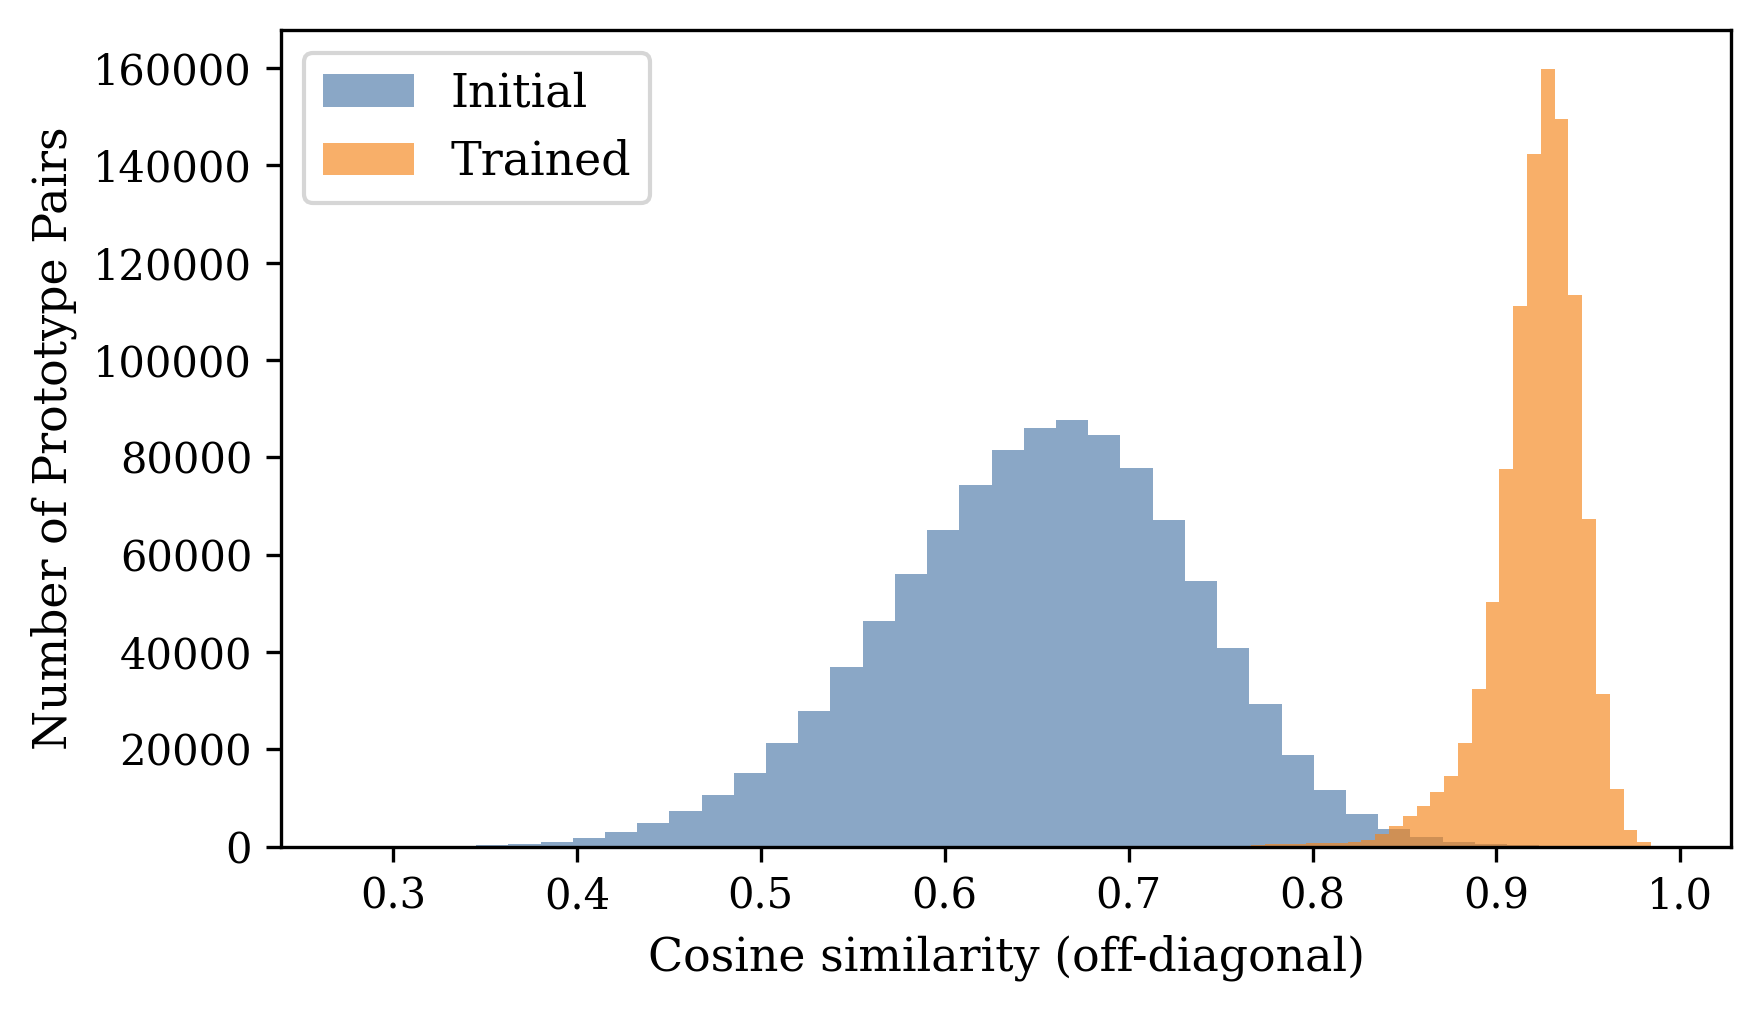

Cosine nearest-neighbour margin (↑ larger gaps)
Initial: mean=0.1299, median=0.1210
Trained: mean=0.0299, median=0.0268


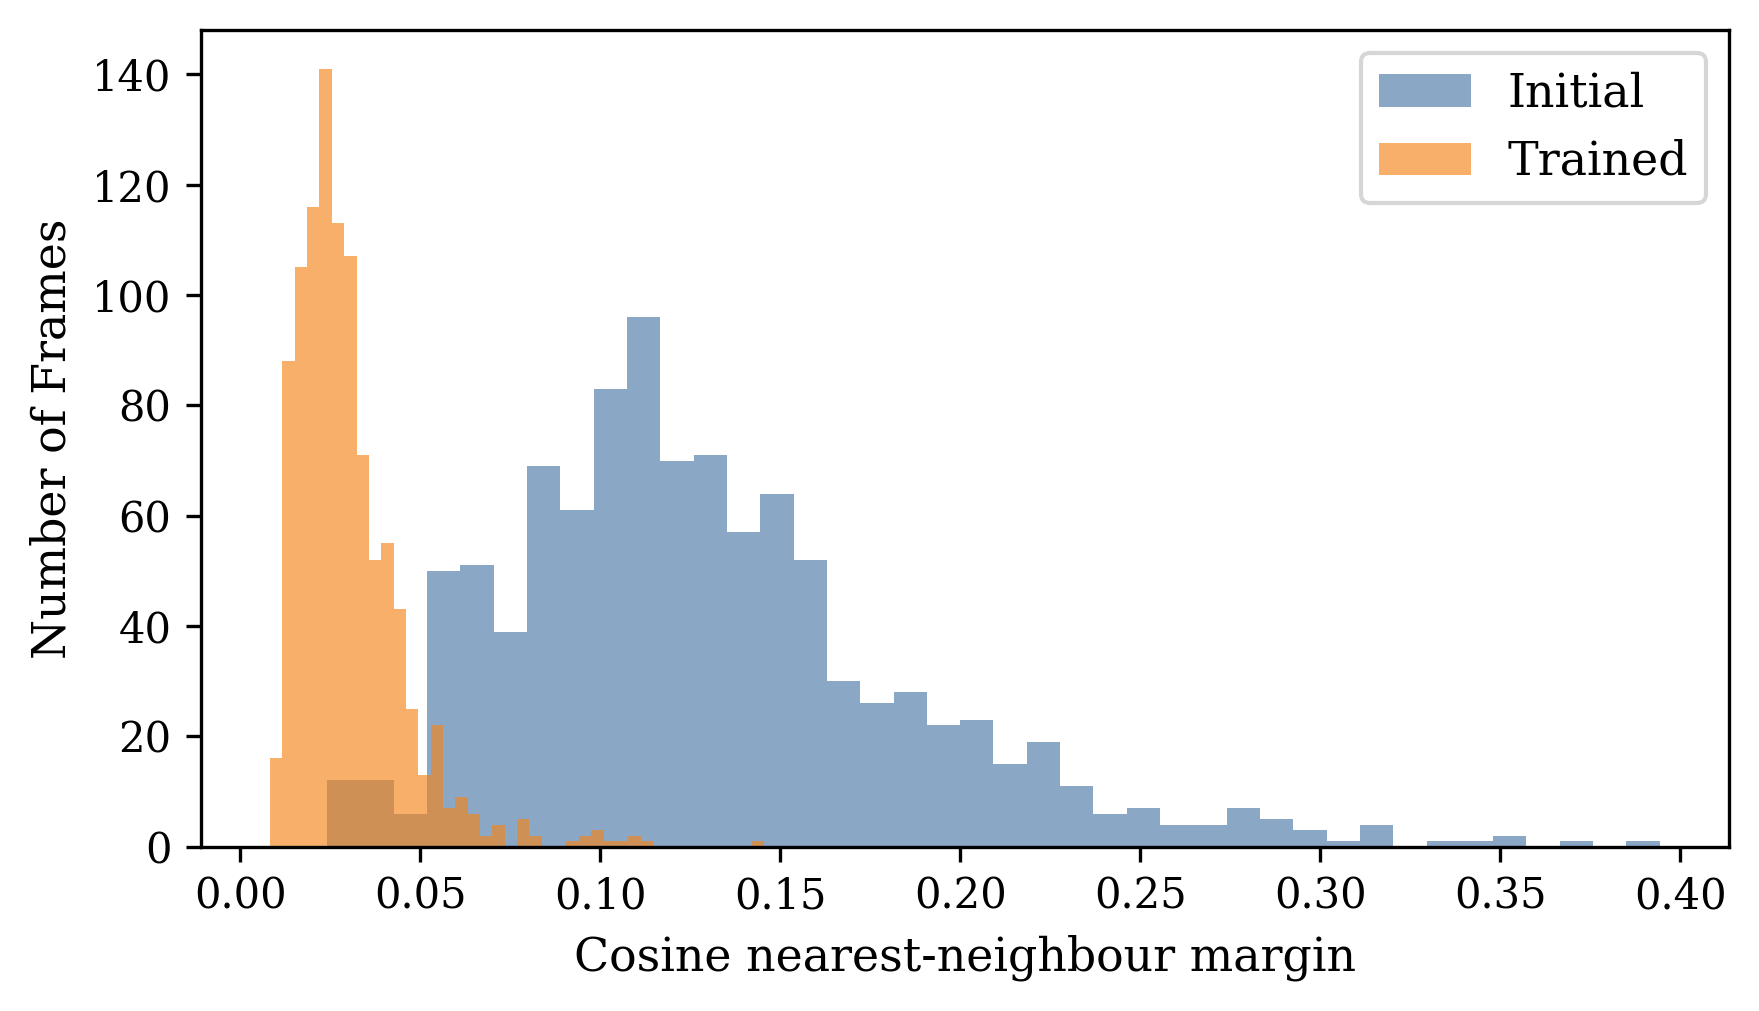

In [ ]:
# -*- coding: utf-8 -*-
# Visualization: prototype geometry before vs after training (cosine-based)
# Figure 11: Inter-class cosine similarity (↓ better separation)
# Figure 12: Cosine nearest-neighbour margin (↑ larger margin)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ======= CONFIG =======
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "axes.labelsize": 11,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300
})

COL_INIT   = "#4C78A8"
COL_TRAIN  = "#F58518"
ALPHA      = 0.65
BINS       = 40

# ======= Utils =======
def offdiag_cosine_values(X: np.ndarray):
    """Off-diagonal cosine similarity stats."""
    S = cosine_similarity(X)
    mask = ~np.eye(len(X), dtype=bool)
    vals = S[mask]
    stats = {
        "mean":   float(np.mean(vals)),
        "median": float(np.median(vals)),
        "p90":    float(np.quantile(vals, 0.90)),
        "max":    float(np.max(vals)),
    }
    return stats, vals

def nn_gap_cosine(X: np.ndarray):
    """Cosine NN margin = 1 − max_{j ≠ i} cos(x_i, x_j)."""
    S = cosine_similarity(X)
    np.fill_diagonal(S, -np.inf)
    nn_sim = np.max(S, axis=1)
    return 1.0 - nn_sim  # margin

# ======= Inputs =======
# init_mat = ...
# trn_mat  = ...

# 1) Off-diagonal cosine similarity (Figure 11)
init_stat, init_vals = offdiag_cosine_values(init_mat)
trn_stat,  trn_vals  = offdiag_cosine_values(trn_mat)

print("Off-diagonal cosine similarity (↓ better separation)")
print("Initial:", init_stat)
print("Trained:", trn_stat)

plt.figure(figsize=(6, 3.5))
plt.hist(init_vals, bins=BINS, alpha=ALPHA, color=COL_INIT, label="Initial")
plt.hist(trn_vals,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine similarity (off-diagonal)")
plt.ylabel("Number of Prototype Pairs")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 11

# 2) Cosine nearest-neighbour margin (Figure 12)
init_nn = nn_gap_cosine(init_mat)
trn_nn  = nn_gap_cosine(trn_mat)

print("Cosine nearest-neighbour margin (↑ larger gaps)")
print(f"Initial: mean={init_nn.mean():.4f}, median={np.median(init_nn):.4f}")
print(f"Trained: mean={trn_nn.mean():.4f}, median={np.median(trn_nn):.4f}")

plt.figure(figsize=(6, 3.5))
plt.hist(init_nn, bins=BINS, alpha=ALPHA, color=COL_INIT,  label="Initial")
plt.hist(trn_nn,  bins=BINS, alpha=ALPHA, color=COL_TRAIN, label="Trained")
plt.xlabel("Cosine nearest-neighbour margin")
plt.ylabel("Number of Frames")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()  # Figure 12



In [ ]:
# @title ✅ Main Training Model (Single-Prototype)

def load_checkpoint_safely(checkpoint_path, map_location="cpu"):
    """Safe checkpoint loader compatible with weights_only=False."""
    try:
        return torch.load(checkpoint_path, map_location=map_location, weights_only=False)
    except TypeError:
        return torch.load(checkpoint_path, map_location=map_location)
    except Exception as e:
        print(f"Load failed: {e}")
        return None

def _sync_best_model(checkpoint_dir):
    """Silently ensure best_model.pt matches the highest val_acc among checkpoints."""
    if not os.path.isdir(checkpoint_dir):
        return
    ckpt_files = sorted(f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_") and f.endswith(".pt"))
    if not ckpt_files:
        return
    best_acc = float("-inf")
    best_file = None
    for f in ckpt_files:
        p = os.path.join(checkpoint_dir, f)
        ckpt = load_checkpoint_safely(p, map_location="cpu")
        if ckpt and "val_acc" in ckpt and isinstance(ckpt["val_acc"], (int, float)):
            if ckpt["val_acc"] > best_acc:
                best_acc = ckpt["val_acc"]
                best_file = f
    if best_file:
        src = os.path.join(checkpoint_dir, best_file)
        dst = os.path.join(checkpoint_dir, "best_model.pt")
        try:
            if os.path.exists(dst):
                shutil.copy2(dst, os.path.join(checkpoint_dir, "best_model_backup.pt"))
            shutil.copy2(src, dst)
        except Exception as e:
            print(f"Best model sync skipped: {e}")

class OptimizedPrototypeLossWithSeparation(nn.Module):
    def __init__(self, initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True):
        super().__init__()
        self.initial_temperature = initial_temperature
        self.current_temperature = initial_temperature
        self.sep_weight = sep_weight
        self.adaptive_temp = adaptive_temp

    def update_temperature(self, epoch, max_epochs):
        """Keep the original cosine decay schedule without a manual lower bound."""
        if self.adaptive_temp:
            decay_factor = 0.6 + 0.4 * np.cos(np.pi * epoch / max_epochs)
            self.current_temperature = self.initial_temperature * decay_factor

    def forward(self, embeddings, labels, prototypes, epoch=0, max_epochs=8):
        device = embeddings.device
        self.update_temperature(epoch, max_epochs)

        frame_names = list(prototypes.keys())
        proto_list = [prototypes[f] for f in frame_names]
        prototype_matrix = torch.stack(proto_list).to(device)

        frame_to_idx = {f: i for i, f in enumerate(frame_names)}
        target_indices = torch.tensor([frame_to_idx[label] for label in labels], device=device)

        sim_matrix = torch.matmul(embeddings, prototype_matrix.T) / self.current_temperature
        loss_ce = F.cross_entropy(sim_matrix, target_indices)

        if len(proto_list) > 1:
            proto_norm = F.normalize(prototype_matrix, dim=-1)
            sim_proto = torch.matmul(proto_norm, proto_norm.T)
            mask = ~torch.eye(len(proto_norm), dtype=bool, device=device)
            off_diagonal_sims = sim_proto[mask]
            sep_loss = torch.relu(off_diagonal_sims - 0.4).mean()
        else:
            sep_loss = torch.tensor(0.0, device=device)

        total_loss = loss_ce + self.sep_weight * sep_loss
        return total_loss, {
            'cross_entropy': loss_ce.item(),
            'separation': sep_loss.item(),
            'total': total_loss.item(),
            'temperature': self.current_temperature
        }

class SimpleFrameDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {'sentence': row['sentence'], 'target_spans': row['target_spans'], 'frame_name': row['frame_name']}

def collate_fn(batch):
    return {
        'sentence': [x['sentence'] for x in batch],
        'target_spans': [x['target_spans'] for x in batch],
        'frame_name': [x['frame_name'] for x in batch]
    }

def stratified_evaluation(model, tokenizer, val_df, prototypes, train_counts):
    print("\nStratified evaluation:")
    groups = [('Rich', 50, float('inf')), ('Medium', 20, 49), ('Poor', 10, 19), ('Very Poor', 0, 9)]
    for name, min_c, max_c in groups:
        frames = train_counts[(train_counts >= min_c) & (train_counts <= max_c)].index
        sub_df = val_df[val_df['frame_name'].isin(frames)]
        if len(sub_df) == 0:
            continue
        result = evaluate_target_known(model, tokenizer, sub_df, prototypes, batch_size=64)
        print(f"   {name:<12} ({len(sub_df)} samples) Top-1: {result['top1_accuracy']:.3f} | Macro F1: {result['macro_f1']:.3f}")

class OptimizedPrototypeLearner:
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints"):
        self.device = device
        self.model = AutoModel.from_pretrained(model_name).to(device)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.criterion = OptimizedPrototypeLossWithSeparation(initial_temperature=0.1, sep_weight=0.15, adaptive_temp=True)
        self.prototypes = {}
        self.best_val = 0.0
        self.save_dir = save_dir
        self.best_model_path = None
        os.makedirs(save_dir, exist_ok=True)

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        """Save checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'best_val_acc': self.best_val,
            'val_acc': val_acc,
            'loss': loss,
            'criterion_state': {
                'current_temperature': self.criterion.current_temperature,
                'initial_temperature': self.criterion.initial_temperature,
                'sep_weight': self.criterion.sep_weight
            }
        }
        if is_best:
            save_path = f"{self.save_dir}/best_model.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"  Best model saved: {save_path}")
            return save_path
        else:
            save_path = f"{self.save_dir}/checkpoint_epoch{epoch}.pt"
            torch.save(checkpoint, save_path)
            print(f"  Checkpoint saved: {save_path}")
            return save_path

    def load_checkpoint(self, checkpoint_path):
        """Load checkpoint using safe loader."""
        checkpoint = load_checkpoint_safely(checkpoint_path, map_location=self.device)
        if checkpoint is None:
            raise RuntimeError(f"Failed to load checkpoint: {checkpoint_path}")
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.prototypes = checkpoint['prototypes']
        self.best_val = checkpoint.get('best_val_acc', 0.0)
        if 'criterion_state' in checkpoint:
            cs = checkpoint['criterion_state']
            self.criterion.current_temperature = cs.get('current_temperature', self.criterion.current_temperature)
            self.criterion.initial_temperature = cs.get('initial_temperature', self.criterion.initial_temperature)
            self.criterion.sep_weight = cs.get('sep_weight', self.criterion.sep_weight)
        print(f"Loaded checkpoint: {checkpoint_path}")
        print(f"   Resumed epoch: {checkpoint.get('epoch','?')}, Best accuracy: {self.best_val:.4f}")
        return checkpoint.get('epoch', 0)

    def train(self, train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3, save_every=2):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)

        train_counts = train_df['frame_name'].value_counts()
        train_loader = DataLoader(
            SimpleFrameDataset(train_df, self.tokenizer),
            batch_size=32, shuffle=True, collate_fn=collate_fn,
            generator=torch.Generator().manual_seed(42), num_workers=0
        )

        patience_counter = 0
        print(f"\n{'='*60}\nStart Training\n{'='*60}")
        print(f"Training samples: {len(train_df):,}")
        print(f"Validation samples: {len(val_df):,}")
        print(f"Frames: {len(train_counts):,}")
        print(f"Save directory: {self.save_dir}")

        for ep in range(epochs):
            self.model.train()
            epoch_losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(
                    batch['sentence'], batch['target_spans'],
                    self.tokenizer, self.model,
                    batch_size=len(batch['sentence']), train_mode=True
                )
                loss, loss_dict = self.criterion(
                    embs, batch['frame_name'], self.prototypes,
                    epoch=ep, max_epochs=epochs
                )
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                epoch_losses['total'].append(loss_dict['total'])
                epoch_losses['cross_entropy'].append(loss_dict['cross_entropy'])
                epoch_losses['separation'].append(loss_dict['separation'])

                pbar.set_postfix({
                    'Loss': f"{loss_dict['total']:.3f}",
                    'CE': f"{loss_dict['cross_entropy']:.3f}",
                    'Sep': f"{loss_dict['separation']:.3f}",
                    'Temp': f"{loss_dict['temperature']:.3f}"
                })

            scheduler.step()
            avg_total_loss = np.mean(epoch_losses['total'])
            avg_ce_loss = np.mean(epoch_losses['cross_entropy'])
            avg_sep_loss = np.mean(epoch_losses['separation'])
            current_temp = loss_dict['temperature']
            print(f"Loss - Total: {avg_total_loss:.4f} | CE: {avg_ce_loss:.4f} | Sep: {avg_sep_loss:.4f} | Temp: {current_temp:.3f}")

            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            result = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)
            acc = result['top1_accuracy']
            print(f"Validation accuracy: {acc:.4f}")

            print("\nStratified evaluation results:")
            stratified_evaluation(self.model, self.tokenizer, val_df, self.prototypes, train_counts)

            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1

            if (ep + 1) % save_every == 0:
                self.save_checkpoint(ep+1, acc, avg_total_loss)

            if patience_counter >= patience:
                print(f"No improvement for {patience} epochs, early stopping")
                break

        return self

    def build_prototypes(self, df):
        """Build prototypes with outlier filtering."""
        frame2embeds = defaultdict(list)
        for i in tqdm(range(0, len(df), 32), desc="Encoding spans"):
            batch = df.iloc[i:i+32]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    self.tokenizer, self.model,
                    batch_size=32, train_mode=False
                )
                for f, e in zip(batch['frame_name'], embs):
                    frame2embeds[f].append(e)
            except Exception as e:
                print(f"  Batch error: {e}")
                continue

        self.prototypes = {}
        for f, vecs in tqdm(frame2embeds.items(), desc="Computing prototypes"):
            if not vecs:
                continue
            X = torch.stack([v.cpu() if isinstance(v, torch.Tensor) else torch.tensor(v) for v in vecs])
            if len(X) > 10:
                center = X.mean(0)
                distances = torch.norm(X - center, dim=1)
                keep_ratio = 0.85
                keep_num = max(3, int(len(X) * keep_ratio))
                _, keep_indices = torch.topk(distances, keep_num, largest=False)
                X = X[keep_indices]
            self.prototypes[f] = X.mean(0)

def run_training():
    def set_seed(seed=42):
        import os, random
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")
    print(f"Random seed set: 42")

    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print("\nData loaded")
    print(f"Training samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    print(f"Frames: {len(train_df['frame_name'].unique()):,}")

    learner = OptimizedPrototypeLearner(device)
    learner.train(train_df, val_df, epochs=25, lr=1e-5, rebuild_every=2, patience=3, save_every=2)

    # Silent best-model sync
    _sync_best_model(learner.save_dir)

    baseline_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"\nBaseline (single prototype) Top-1 Accuracy: {baseline_result['top1_accuracy']:.4f}")
    return learner

# @title ✅ Run Training
learner = run_training()


In [ ]:
# @title ✅ Test Best Model Performance

def test_best_model():
    """Evaluate the best model on the test sets"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Load best model
    model_path = "/content/drive/MyDrive/more50/framenet_data/checkpoints/best_model.pt"
    print(f"Loading model: {model_path}")

    # Create learner and load model
    learner = OptimizedPrototypeLearner(device)
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    learner.model.load_state_dict(checkpoint['model_state_dict'])

    # Convert prototypes to CPU numpy format for evaluation
    raw_prototypes = checkpoint['prototypes']
    learner.prototypes = {}
    for frame_name, proto in raw_prototypes.items():
        if isinstance(proto, torch.Tensor):
            learner.prototypes[frame_name] = proto.cpu().numpy()
        else:
            learner.prototypes[frame_name] = proto

    print(f"Model loaded successfully, number of prototypes: {len(learner.prototypes)}")

    # Load training data for stratified evaluation
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    train_counts = train_df['frame_name'].value_counts()

    # 1. Original test set
    print("\n" + "="*50)
    print("Original Test Set")
    print("="*50)
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"Number of samples: {len(test_df):,}")

    result1 = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"Top-1 Accuracy: {result1['top1_accuracy']:.4f}")
    print(f"Top-3 Accuracy: {result1['top3_accuracy']:.4f}")
    print(f"Macro F1: {result1['macro_f1']:.4f}")
    print(f"Weighted F1: {result1['weighted_f1']:.4f}")

    # Stratified evaluation
    stratified_evaluation(learner.model, learner.tokenizer, test_df, learner.prototypes, train_counts)

    # 2. Full Text test set
    print("\n" + "="*50)
    print("Full Text Test Set")
    print("="*50)
    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"
    full_test_df = pd.read_pickle(test_path)
    print(f"Number of samples: {len(full_test_df):,}")

    result2 = evaluate_target_known(learner.model, learner.tokenizer, full_test_df, learner.prototypes)
    print(f"Top-1 Accuracy: {result2['top1_accuracy']:.4f}")
    print(f"Top-3 Accuracy: {result2['top3_accuracy']:.4f}")
    print(f"Macro F1: {result2['macro_f1']:.4f}")
    print(f"Weighted F1: {result2['weighted_f1']:.4f}")

    # Stratified evaluation on full text
    stratified_evaluation(learner.model, learner.tokenizer, full_test_df, learner.prototypes, train_counts)

    # Comparison
    print("\n" + "="*50)
    print("Results Comparison")
    print("="*50)
    print(f"{'Metric':<15} {'Original Test':<12} {'Full Text':<12} {'Difference':<10}")
    print("-" * 50)
    print(f"Top-1 Accuracy  {result1['top1_accuracy']:.4f}       {result2['top1_accuracy']:.4f}       {result2['top1_accuracy']-result1['top1_accuracy']:+.4f}")
    print(f"Top-3 Accuracy  {result1['top3_accuracy']:.4f}       {result2['top3_accuracy']:.4f}       {result2['top3_accuracy']-result1['top3_accuracy']:+.4f}")
    print(f"Macro F1        {result1['macro_f1']:.4f}       {result2['macro_f1']:.4f}       {result2['macro_f1']-result1['macro_f1']:+.4f}")
    print(f"Weighted F1     {result1['weighted_f1']:.4f}       {result2['weighted_f1']:.4f}       {result2['weighted_f1']-result1['weighted_f1']:+.4f}")

# Run test
test_best_model()


In [ ]:
# @title ✅ Full Dataset Clustering Test
from sklearn.metrics import davies_bouldin_score
from glob import glob

def auto_kmeans_dbi(embeddings, max_k=5):
    """Automatically select number of clusters (KMeans) using DBI"""
    if len(embeddings) == 1:
        return [embeddings[0]]
    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)]  # Not enough to cluster, just average

    best_score = float("inf")
    best_centers = None
    for k in range(2, min(max_k, len(embeddings))):
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(embeddings)
        score = davies_bouldin_score(embeddings, labels)
        if score < best_score:
            best_score = score
            best_centers = kmeans.cluster_centers_

    if best_centers is not None:
        return list(best_centers)
    else:
        return [np.mean(embeddings, axis=0)]

def load_best_trained_model():
    """Load the best trained model"""
    print("🚀 Loading the best trained model...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints"

    possible_paths = [
        f"{checkpoint_dir}/best_model.pt",
        f"{checkpoint_dir}/complete_model_final.pt",
        f"{checkpoint_dir}/first_stage_complete.pt"
    ]

    other_best_files = glob(f"{checkpoint_dir}/best_model*.pt")
    possible_paths.extend(other_best_files)

    best_model_path = None
    for path in possible_paths:
        if os.path.exists(path):
            best_model_path = path
            print(f"📁 Found model: {os.path.basename(path)}")
            break

    if not best_model_path:
        print("❌ No best model file found!")
        return None, None, None, None

    model = AutoModel.from_pretrained("distilbert-base-uncased").to(device)
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

    try:
        checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])

        if 'best_val_acc' in checkpoint:
            best_acc = checkpoint['best_val_acc']
        elif 'final_accuracy' in checkpoint:
            best_acc = checkpoint['final_accuracy']
        elif 'baseline_accuracy' in checkpoint:
            best_acc = checkpoint['baseline_accuracy']
        else:
            best_acc = 0.0

        print(f"✅ Model loaded successfully, best training accuracy: {best_acc:.4f}")
        return model, tokenizer, device, best_acc

    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        return None, None, None, None

def build_clustered_prototypes_from_trained_model(model, tokenizer, train_df, device):
    """Re-encode training data with trained model and build clustered prototypes"""
    print("\n🔄 Re-encoding training data and building clustered prototypes...")

    model.eval()
    frame2embeds = defaultdict(list)

    with torch.no_grad():
        for i in tqdm(range(0, len(train_df), 64), desc="Re-encoding training data"):
            batch = train_df.iloc[i:i+64]
            try:
                embs = encode_target_spans_batch(
                    batch['sentence'].tolist(),
                    batch['target_spans'].tolist(),
                    tokenizer, model,
                    batch_size=len(batch), train_mode=False
                )

                for j, frame_name in enumerate(batch['frame_name']):
                    if torch.is_tensor(embs[j]):
                        frame2embeds[frame_name].append(embs[j].cpu().numpy())
                    else:
                        frame2embeds[frame_name].append(embs[j])

            except Exception as e:
                print(f"Batch encoding error: {e}")
                continue

    print(f"Encoding finished, collected embeddings for {len(frame2embeds)} frames")

    print("\n🎯 Clustering for each frame...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0
    }

    for frame, embeds in tqdm(frame2embeds.items(), desc="Clustering prototypes"):
        embeds = np.array(embeds)

        if len(embeds) == 1:
            frame_multi_prototypes[frame] = [embeds[0]]
            clustering_stats['single_prototype'] += 1
            clustering_stats['total_prototypes'] += 1
        else:
            centers = auto_kmeans_dbi(embeds)
            frame_multi_prototypes[frame] = centers

            if len(centers) == 1:
                clustering_stats['single_prototype'] += 1
            else:
                clustering_stats['multi_prototype'] += 1
            clustering_stats['total_prototypes'] += len(centers)

    print("Clustering finished:")
    print(f"  Single-prototype frames: {clustering_stats['single_prototype']}")
    print(f"  Multi-prototype frames: {clustering_stats['multi_prototype']}")
    print(f"  Total prototypes: {clustering_stats['total_prototypes']}")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """Evaluate using multi-prototype approach, choosing the closest sub-prototype for each sample"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 Evaluating with multi-prototype system")

    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 Evaluating {len(test_df)} test samples with {len(all_prototype_vectors)} prototypes (from {len(frame_multi_prototypes)} frames)")

    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    valid_indices, valid_sentences, valid_spans, valid_frames = [], [], [], []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_indices.append(i)
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 Valid test samples: {len(valid_indices)}/{len(test_df)}")

    with torch.no_grad():
        test_embeddings_tensor = encode_target_spans_batch(
            valid_sentences, valid_spans, tokenizer, model,
            batch_size=batch_size, train_mode=False
        )
        test_embeddings = test_embeddings_tensor.detach().cpu().numpy()

    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true, y_pred_top1, y_pred_top3 = [], [], []
    correct_top1, correct_top3 = 0, 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)
        y_pred_top3.append(top3_preds)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_precision": macro_p,
        "macro_recall": macro_r,
        "macro_f1": macro_f,
        "weighted_precision": weighted_p,
        "weighted_recall": weighted_r,
        "weighted_f1": weighted_f,
        "total_samples": len(valid_frames),
        "valid_samples": len(valid_frames),
        "prototype_count": len(all_prototype_vectors),
        "frame_count": len(frame_multi_prototypes)
    }

    print(f"\n✅ Multi-prototype evaluation results (closest sub-prototype strategy)")
    print(f"Top-1 Accuracy: {results['top1_accuracy']:.4f}")
    print(f"Top-3 Accuracy: {results['top3_accuracy']:.4f}")
    print(f"Macro F1: {results['macro_f1']:.4f}")
    print(f"Weighted F1: {results['weighted_f1']:.4f}")
    print(f"Samples processed: {results['valid_samples']}/{len(test_df)}")
    print(f"Prototypes used: {results['prototype_count']} (from {results['frame_count']} frames)")

    return results

def test_clustered_model_on_datasets():
    """Test clustered model on two test sets"""
    print("="*80)
    print("Testing best trained model + clustered prototypes on two test sets")
    print("="*80)

    model, tokenizer, device, train_best_acc = load_best_trained_model()
    if model is None:
        return None

    print("\n📊 Loading training data...")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    print(f"Training data: {len(train_df):,} samples")

    frame_multi_prototypes, clustering_stats = build_clustered_prototypes_from_trained_model(
        model, tokenizer, train_df, device
    )

    multi_prototype_info = {}
    for frame_name, prototypes in frame_multi_prototypes.items():
        multi_prototype_info[frame_name] = {
            'count': len(prototypes),
            'method': 'multi_closest' if len(prototypes) > 1 else 'single'
        }

    print("\n📊 Loading test sets...")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    print(f"Original test set: {len(test_df_original):,} samples")
    print(f"Fulltext test set: {len(test_df_fulltext):,} samples")

    results = {}

    print(f"\n" + "="*60)
    print("📊 Testing clustered model on original test set...")
    print("="*60)
    try:
        model.eval()
        result_original = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_original, frame_multi_prototypes
        )
        results['original_test'] = result_original
    except Exception as e:
        print(f"❌ Original test set evaluation failed: {e}")
        import traceback; traceback.print_exc()
        results['original_test'] = None

    print(f"\n" + "="*60)
    print("🎯 Testing clustered model on fulltext test set...")
    print("="*60)
    try:
        model.eval()
        result_fulltext = evaluate_with_multi_prototypes(
            model, tokenizer, test_df_fulltext, frame_multi_prototypes
        )
        results['fulltext_test'] = result_fulltext
    except Exception as e:
        print(f"❌ Fulltext test set evaluation failed: {e}")
        import traceback; traceback.print_exc()
        results['fulltext_test'] = None

    print(f"\n" + "="*80)
    print("Clustered model evaluation summary (closest sub-prototype strategy)")
    print("="*80)

    print(f"Model info:")
    print(f"  Best training accuracy: {train_best_acc:.4f}")
    print(f"  Clustering stats: {clustering_stats}")

    multi_frames = sum(1 for info in multi_prototype_info.values() if info['count'] > 1)
    total_prototypes = sum(info['count'] for info in multi_prototype_info.values())
    print(f"  Multi-prototype frames: {multi_frames}/{len(multi_prototype_info)}")
    print(f"  Total prototypes: {total_prototypes}")

    print(f"\nTest set results:")
    print(f"{'Dataset':<15} {'Top-1':<8} {'Top-3':<8} {'Macro F1':<10} {'Weighted F1':<12}")
    print("-" * 60)

    if results['original_test']:
        orig = results['original_test']
        print(f"{'Original Test':<15} {orig['top1_accuracy']:<8.4f} {orig['top3_accuracy']:<8.4f} {orig['macro_f1']:<10.4f} {orig['weighted_f1']:<12.4f}")

    if results['fulltext_test']:
        full = results['fulltext_test']
        print(f"{'Fulltext Test':<15} {full['top1_accuracy']:<8.4f} {full['top3_accuracy']:<8.4f} {full['macro_f1']:<10.4f} {full['weighted_f1']:<12.4f}")

    save_results_to_drive(results, clustering_stats, multi_prototype_info)
    return results, clustering_stats, multi_prototype_info

def save_results_to_drive(results, clustering_stats, multi_prototype_info):
    """Save results to Google Drive"""
    save_dir = "/content/drive/MyDrive/more50/framenet_data/clustering_test_results"
    os.makedirs(save_dir, exist_ok=True)

    save_data = {
        'test_results': results,
        'clustering_stats': clustering_stats,
        'multi_prototype_info': multi_prototype_info,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    save_path = f"{save_dir}/clustered_model_test_results.pkl"
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(save_data, f)

    print(f"\n💾 Results saved to: {save_path}")

def analyze_clustering_results():
    """Simple analysis of clustering results"""
    print(f"\n📈 Clustering results analysis...")
    pass

# Run test
if __name__ == "__main__":
    print("🚀 Starting clustered model evaluation...")

    try:
        results, clustering_stats, multi_prototype_info = test_clustered_model_on_datasets()

        if results:
            print(f"\n✅ Evaluation completed!")

            if results['original_test'] and results['fulltext_test']:
                orig_acc = results['original_test']['top1_accuracy']
                full_acc = results['fulltext_test']['top1_accuracy']

                print(f"\n📊 Performance summary:")
                print(f"  Original test accuracy: {orig_acc:.4f}")
                print(f"  Fulltext test accuracy: {full_acc:.4f}")
                print(f"  Average accuracy: {(orig_acc + full_acc) / 2:.4f}")

                if orig_acc > full_acc:
                    print(f"  Original test performed better (+{orig_acc - full_acc:.4f})")
                else:
                    print(f"  Fulltext test performed better (+{full_acc - orig_acc:.4f})")

        else:
            print(f"❌ Evaluation failed")

    except Exception as e:
        print(f"❌ Error during evaluation: {e}")
        import traceback; traceback.print_exc()


In [ ]:
# @title ✅ Complete Fixed Version: Few-shot Prototype Learner (with Best Model Saving + Test Evaluation)

class OptimizedPrototypeLearnerWithFewShot(OptimizedPrototypeLearner):
    def __init__(self, device, model_name="distilbert-base-uncased", save_dir="/content/drive/MyDrive/more50/framenet_data/checkpoints", shot_method=None):
        super().__init__(device, model_name, save_dir)
        if shot_method:
            self.shot_method = shot_method
            self.save_dir = f"{save_dir}/{shot_method}_training"
            os.makedirs(self.save_dir, exist_ok=True)
            print(f"Training with method: {shot_method}")

    def generate_few_shot_dataset(self, train_df, shot_num):
        print(f"\nGenerating {shot_num}-shot training dataset...")
        few_shot_samples = []
        frame_groups = train_df.groupby('frame_name')
        stats = {'sufficient_samples': 0, 'insufficient_samples': 0, 'total_samples': 0}

        for frame_name, group in frame_groups:
            if len(group) >= shot_num:
                sampled = group.sample(n=shot_num, random_state=42)
                stats['sufficient_samples'] += 1
            else:
                sampled = group
                stats['insufficient_samples'] += 1
            few_shot_samples.append(sampled)
            stats['total_samples'] += len(sampled)

        few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
        print(f"{shot_num}-shot dataset generated:")
        print(f"   Total samples: {len(few_shot_df):,}")
        print(f"   Frames with sufficient samples: {stats['sufficient_samples']}")
        print(f"   Frames with insufficient samples: {stats['insufficient_samples']}")
        print(f"   Avg per frame: {stats['total_samples']/len(frame_groups):.1f} samples")
        return few_shot_df

    def save_checkpoint(self, epoch, val_acc, loss, is_best=False):
        if is_best:
            if torch.is_tensor(loss):
                loss = loss.detach().cpu().item()

            checkpoint = {
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'prototypes': self.prototypes.copy(),
                'best_val_acc': self.best_val,
                'val_acc': val_acc,
                'loss': loss,
                'criterion_state': {
                    'current_temperature': self.criterion.current_temperature,
                    'initial_temperature': self.criterion.initial_temperature,
                    'sep_weight': self.criterion.sep_weight
                }
            }
            save_path = f"{self.save_dir}/best_model_ep{epoch}_acc{val_acc:.4f}.pt"
            torch.save(checkpoint, save_path)
            self.best_model_path = save_path
            print(f"Best model saved: {save_path}")
            return save_path
        return None

    def load_checkpoint(self, checkpoint_path):
        import torch.serialization
        torch.serialization.add_safe_globals([np.core.multiarray.scalar])
        try:
            checkpoint = torch.load(checkpoint_path, map_location=self.device, weights_only=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.prototypes = checkpoint['prototypes']
            self.best_val = checkpoint['best_val_acc']
            if 'criterion_state' in checkpoint:
                cs = checkpoint['criterion_state']
                self.criterion.current_temperature = cs['current_temperature']
                self.criterion.initial_temperature = cs['initial_temperature']
                self.criterion.sep_weight = cs['sep_weight']
            print(f"Checkpoint successfully loaded: {checkpoint_path}")
            print(f"   Restored epoch: {checkpoint['epoch']}, Best accuracy: {self.best_val:.4f}")
            return checkpoint['epoch']
        except Exception as e:
            print(f"Loading failed: {e}")
            print(f"Path attempted: {checkpoint_path}")
            return 0

    def train(self, train_df, val_df, epochs=20, lr=2e-6, rebuild_every=1, patience=4):
        self.build_prototypes(train_df)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01, eps=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr * 0.1)
        train_loader = DataLoader(SimpleFrameDataset(train_df, self.tokenizer), batch_size=32, shuffle=True, collate_fn=collate_fn)
        patience_counter = 0

        def safe_mean(tensor_list):
            values = []
            for x in tensor_list:
                if torch.is_tensor(x):
                    values.append(x.detach().cpu().item())
                else:
                    values.append(x)
            return np.mean(values) if values else 0.0

        for ep in range(epochs):
            self.model.train()
            losses = {'total': [], 'cross_entropy': [], 'separation': []}
            pbar = tqdm(train_loader, desc=f"Training Epoch {ep+1}", leave=False)

            for batch in pbar:
                embs = encode_target_spans_batch(batch['sentence'], batch['target_spans'], self.tokenizer, self.model, batch_size=len(batch['sentence']), train_mode=True)
                loss, loss_dict = self.criterion(embs, batch['frame_name'], self.prototypes, epoch=ep, max_epochs=epochs)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()

                for k in losses:
                    if torch.is_tensor(loss_dict[k]):
                        losses[k].append(loss_dict[k].detach().cpu().item())
                    else:
                        losses[k].append(loss_dict[k])

                display_dict = {}
                for k in ['total', 'cross_entropy', 'separation']:
                    if torch.is_tensor(loss_dict[k]):
                        display_dict[k] = f"{loss_dict[k].detach().cpu().item():.3f}"
                    else:
                        display_dict[k] = f"{loss_dict[k]:.3f}"
                pbar.set_postfix(display_dict)

            scheduler.step()

            avg_total_loss = safe_mean(losses['total'])
            avg_ce_loss = safe_mean(losses['cross_entropy'])
            avg_sep_loss = safe_mean(losses['separation'])

            acc = evaluate_target_known(self.model, self.tokenizer, val_df, self.prototypes)['top1_accuracy']
            print(f"Validation accuracy: {acc:.4f} | Loss: {avg_total_loss:.4f}")

            if (ep + 1) % rebuild_every == 0:
                self.build_prototypes(train_df)

            is_best = acc > self.best_val
            if is_best:
                self.best_val = acc
                self.save_checkpoint(ep+1, acc, avg_total_loss, is_best=True)
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"No improvement for {patience} epochs, early stopping")
                    break

        if hasattr(self, 'best_model_path') and self.best_model_path and os.path.exists(self.best_model_path):
            self.load_checkpoint(self.best_model_path)
        else:
            print("No best model found, using last state")

        torch.save({
            'epoch': ep+1,
            'model_state_dict': self.model.state_dict(),
            'prototypes': self.prototypes.copy(),
            'val_acc': acc,
        }, f"{self.save_dir}/final_model.pt")
        print(f"Final model saved")
        return self

    def train_with_method(self, train_df, val_df, epochs=20, lr=2e-6):
        if self.shot_method.endswith('-shot'):
            shot_num = int(self.shot_method.split('-')[0])
            training_df = self.generate_few_shot_dataset(train_df, shot_num)
        else:
            raise ValueError(f"Unsupported method: {self.shot_method}")
        return self.train(training_df, val_df, epochs=epochs, lr=lr, rebuild_every=1, patience=4)

def evaluate_on_test(learner):
    test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    print(f"\nLoading test set: {len(test_df):,} samples")
    result = evaluate_target_known(learner.model, learner.tokenizer, test_df, learner.prototypes)
    print(f"\nTest evaluation complete: Top-1: {result['top1_accuracy']:.4f}, Macro F1: {result['macro_f1']:.4f}")
    return result

def run_single_method_training(method='5-shot', epochs=20):
    def set_seed(seed=42):
        import random, os
        os.environ["PYTHONHASHSEED"] = str(seed)
        random.seed(seed); np.random.seed(seed)
        torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    set_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    val_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/val_df.pkl")

    print(f"\n🚀 Starting {method} training...")
    learner = OptimizedPrototypeLearnerWithFewShot(device, shot_method=method)
    learner.train_with_method(train_df, val_df, epochs=epochs)

    print(f"\n📊 {method} training finished, starting final evaluation...")

    print("=" * 50)
    print("📈 Validation set evaluation:")
    val_result = evaluate_target_known(learner.model, learner.tokenizer, val_df, learner.prototypes)
    print(f"Val Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")

    print("=" * 50)
    print("🎯 Test set evaluation:")
    test_result = evaluate_on_test(learner)

    print("=" * 50)
    print(f"✅ {method} training and evaluation complete!")
    print(f"📊 Final Results:")
    print(f"   Validation - Top-1: {val_result['top1_accuracy']:.4f}, Macro F1: {val_result['macro_f1']:.4f}")
    print(f"   Test - Top-1: {test_result['top1_accuracy']:.4f}, Macro F1: {test_result['macro_f1']:.4f}")

    return learner, val_result, test_result


# Run training
if __name__ == "__main__":
    # Strategy B: frequent prototype rebuild, lower learning rate, more epochs

    # 3-shot training
    learner, val_result, test_result = run_single_method_training('3-shot', epochs=20)

    # 5-shot training
    learner, val_result, test_result = run_single_method_training('5-shot', epochs=20)

    # 10-shot training
    learner, val_result, test_result = run_single_method_training('10-shot', epochs=20)


In [ ]:
# @title ✅ Fulltext Evaluation for Few-shot Models (3-shot, 5-shot, 10-shot)


def load_best_model(shot_method):
    """Load the best model for a given few-shot method"""
    print(f"\n🚀 Loading best {shot_method} model...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Search for best model checkpoint
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ No best model found for {shot_method}!")
        return None

    # Select the model with the highest validation accuracy
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]  # fallback

    print(f"📁 Selected model: {best_model_path}")

    try:
        # Create learner
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # Load checkpoint
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ Failed to load {shot_method} model!")
            return None

        print(f"✅ Successfully loaded {shot_method} model (epoch {epoch}, acc {best_acc:.4f})")
        return learner

    except Exception as e:
        print(f"❌ Error while loading {shot_method} model: {e}")
        return None

def test_on_fulltext(learner, shot_method):
    """Evaluate a model on the Fulltext test set"""
    print(f"\n🎯 Testing {shot_method} model on the Fulltext test set...")

    test_path = "/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl"

    try:
        fulltext_test_df = pd.read_pickle(test_path)
        print(f"📊 Fulltext test set size: {len(fulltext_test_df):,} samples")
    except Exception as e:
        print(f"❌ Failed to load Fulltext test set: {e}")
        return None

    learner.model.eval()

    print("=" * 60)
    print(f"🔥 Running {shot_method} model evaluation on Fulltext...")

    try:
        with torch.no_grad():
            result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                fulltext_test_df,
                learner.prototypes
            )

        print("=" * 60)
        print(f"🎉 {shot_method} model evaluation on Fulltext completed!")
        print(f"📈 Results:")
        print(f"   Top-1 Accuracy: {result['top1_accuracy']:.4f} ({result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 Accuracy: {result['top3_accuracy']:.4f} ({result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {result['macro_f1']:.4f}")
        print(f"   Weighted F1: {result['weighted_f1']:.4f}")
        print(f"   Processed samples: {result['valid_samples']}")
        print(f"   Prototype count: {result['prototype_count']}")

        return result

    except Exception as e:
        print(f"❌ Fulltext evaluation failed for {shot_method}: {e}")
        import traceback
        traceback.print_exc()
        return None

def test_all_models_on_fulltext():
    """Evaluate all best models (3-shot, 5-shot, 10-shot) on the Fulltext test set"""
    print("🚀 Starting evaluation of all best models on Fulltext...")
    print("=" * 80)

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n{'='*20} {shot_method.upper()} MODEL {'='*20}")

        learner = load_best_model(shot_method)
        if learner is None:
            print(f"⚠️  Skipping {shot_method}")
            continue

        result = test_on_fulltext(learner, shot_method)
        if result:
            results[shot_method] = result

        del learner
        torch.cuda.empty_cache()

    # Summary
    print("\n" + "="*80)
    print("📊 Fulltext Test Results Summary:")
    print("="*80)

    if results:
        print(f"{'Model':<10} {'Top-1 Acc':<12} {'Top-3 Acc':<12} {'Macro F1':<10} {'Weighted F1':<12}")
        print("-" * 60)

        for shot_method, result in results.items():
            print(f"{shot_method:<10} {result['top1_accuracy']:<12.4f} {result['top3_accuracy']:<12.4f} {result['macro_f1']:<10.4f} {result['weighted_f1']:<12.4f}")

        best_method = max(results.keys(), key=lambda x: results[x]['top1_accuracy'])
        best_acc = results[best_method]['top1_accuracy']
        print(f"\n🏆 Best performing model on Fulltext: {best_method} (Top-1: {best_acc:.4f})")
    else:
        print("❌ No successful results")

    return results

def test_single_model_fulltext(shot_method):
    """Evaluate a single model on the Fulltext test set"""
    print(f"🎯 Running single-model evaluation for {shot_method} on Fulltext")

    learner = load_best_model(shot_method)
    if learner is None:
        return None

    result = test_on_fulltext(learner, shot_method)

    del learner
    torch.cuda.empty_cache()

    return result

# Run tests
if __name__ == "__main__":
    print("🔥 Choose evaluation mode:")
    print("1. Evaluate all models (3-shot, 5-shot, 10-shot)")
    print("2. Evaluate a single model")

    all_results = test_all_models_on_fulltext()
    # Or run a single model:
    # result = test_single_model_fulltext("3-shot")
    # result = test_single_model_fulltext("5-shot")
    # result = test_single_model_fulltext("10-shot")


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob

def test_3shot_best_model():
    """测试3-shot最佳模型在测试集上的效果"""

    print("🚀 开始测试3-shot最佳模型...")

    # 设备设置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 查找3-shot最佳模型文件
    checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print("❌ 未找到3-shot最佳模型文件！")
        print(f"检查路径: {checkpoint_dir}")
        return None

    # 选择最新的最佳模型文件（按文件名排序）
    best_model_path = sorted(best_model_files)[-1]
    print(f"📁 找到最佳模型: {best_model_path}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method="3-shot"
        )

        # 加载最佳模型
        print("📥 加载最佳模型...")
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print("❌ 模型加载失败！")
            return None

        print(f"✅ 成功加载模型 (epoch {epoch})")

        # 加载测试数据
        print("📊 加载测试数据...")
        test_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
        print(f"测试集大小: {len(test_df):,} 样本")

        # 确保模型在评估模式
        learner.model.eval()

        # 在测试集上评估
        print("🎯 开始测试集评估...")
        print("=" * 60)

        with torch.no_grad():
            test_result = evaluate_target_known_fixed(
                learner.model,
                learner.tokenizer,
                test_df,
                learner.prototypes
            )

        print("=" * 60)
        print("🎉 3-shot模型测试完成！")
        print(f"📈 最终测试结果:")
        print(f"   Top-1 准确率: {test_result['top1_accuracy']:.4f} ({test_result['top1_accuracy']*100:.2f}%)")
        print(f"   Top-3 准确率: {test_result['top3_accuracy']:.4f} ({test_result['top3_accuracy']*100:.2f}%)")
        print(f"   Macro F1: {test_result['macro_f1']:.4f}")
        print(f"   Weighted F1: {test_result['weighted_f1']:.4f}")
        print(f"   处理样本数: {test_result['valid_samples']}")
        print(f"   原型数量: {test_result['prototype_count']}")

        return test_result

    except Exception as e:
        print(f"❌ 测试过程中出现错误: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_test_model_loading():
    """快速测试模型加载功能"""
    print("🔧 快速测试模型加载...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    try:
        # 创建学习器
        learner = OptimizedPrototypeLearnerWithFewShot(device=device, shot_method="3-shot")
        print("✅ 学习器创建成功")

        # 检查模型文件
        checkpoint_dir = "/content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training"
        if os.path.exists(checkpoint_dir):
            files = os.listdir(checkpoint_dir)
            print(f"📁 checkpoint目录内容: {files}")

            best_files = [f for f in files if f.startswith('best_model_')]
            if best_files:
                print(f"🎯 找到最佳模型文件: {best_files}")
            else:
                print("⚠️  未找到最佳模型文件")
        else:
            print(f"❌ checkpoint目录不存在: {checkpoint_dir}")

        return True

    except Exception as e:
        print(f"❌ 快速测试失败: {e}")
        return False

# 运行测试
if __name__ == "__main__":
    print("🧪 开始模型测试...")

    # 先做快速测试
    if quick_test_model_loading():
        print("\n" + "="*60)
        # 再做完整测试
        result = test_3shot_best_model()

        if result:
            print(f"\n🎊 测试成功完成！最终准确率: {result['top1_accuracy']:.4f}")
        else:
            print("\n💥 测试失败，请检查错误信息")
    else:
        print("💥 快速测试失败，无法继续")

🧪 开始模型测试...
🔧 快速测试模型加载...
使用 3-shot 方法训练
✅ 学习器创建成功
📁 checkpoint目录内容: ['checkpoint_epoch2.pt', 'checkpoint_epoch4.pt', 'checkpoint_epoch5.pt', 'best_model.pt', 'best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt', 'final_model.pt']
🎯 找到最佳模型文件: ['best_model_ep1_acc0.4081.pt', 'best_model_ep2_acc0.4265.pt']

🚀 开始测试3-shot最佳模型...
使用设备: cuda
📁 找到最佳模型: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
使用 3-shot 方法训练
📥 加载最佳模型...
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载模型 (epoch 2)
📊 加载测试数据...
测试集大小: 25,527 样本
🎯 开始测试集评估...
📊 使用已有frame原型
🎯 评估 25527 个测试样本，1014 个frame原型
📝 有效测试样本: 25527/25527

✅ Target-known评估结果 (Cosine相似度)
Top-1准确率: 0.4381
Top-3准确率: 0.6180
Macro F1: 0.4219
Weighted F1: 0.4505
处理样本: 25527/25527
🎉 3-shot模型测试完成！
📈 最终测试结果:
   Top-1 准确率: 0.4381 (43.81%)
   Top-3 准确率: 0.6180 (61.80%)
   Macro F1: 0.4219
   Weighted F1: 0.4505
 

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from glob import glob
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support

def few_shot_clustering(embeddings, shot_num, frame_name=None, max_k=3, similarity_threshold=0.7):
    """
    适应few-shot的聚类策略

    Args:
        embeddings: numpy array of embeddings
        shot_num: few-shot数量 (3, 5, 10)
        frame_name: frame名称
        max_k: 最大聚类数
        similarity_threshold: 相似度阈值
    """
    if len(embeddings) <= 1:
        return [embeddings[0]] if len(embeddings) == 1 else [np.zeros(768)], "single_sample"

    if len(embeddings) == 2:
        return [np.mean(embeddings, axis=0)], "two_samples"

    # Few-shot特化的策略
    if shot_num == 3:
        # 3-shot: 非常激进，只要有一点差异就聚类
        min_samples = 2
        max_clusters = 2  # 最多2个簇
        sil_threshold = 0.1
        dist_threshold = 0.05
    elif shot_num == 5:
        # 5-shot: 中等激进
        min_samples = 2
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.15
        dist_threshold = 0.08
    elif shot_num == 10:
        # 10-shot: 相对保守
        min_samples = 3
        max_clusters = 3  # 最多3个簇
        sil_threshold = 0.2
        dist_threshold = 0.1
    else:
        # 其他情况默认策略
        min_samples = max(2, len(embeddings) // 3)
        max_clusters = min(3, len(embeddings) // 2)
        sil_threshold = 0.2
        dist_threshold = 0.1

    # 计算内部相似度
    center = np.mean(embeddings, axis=0, keepdims=True)
    similarities = cosine_similarity(embeddings, center).flatten()
    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    # Few-shot下降低相似度要求
    if avg_similarity > similarity_threshold:
        return [np.mean(embeddings, axis=0)], f"high_similarity_{avg_similarity:.3f}"

    # 尝试聚类
    best_score = float("inf")
    best_centers = None
    best_k = 1

    actual_max_k = min(max_clusters + 1, len(embeddings))

    for k in range(2, actual_max_k):
        if k > len(embeddings):
            break

        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
            labels = kmeans.fit_predict(embeddings)

            # 确保每个簇至少有足够样本
            unique_labels, counts = np.unique(labels, return_counts=True)
            if np.min(counts) < min_samples:
                continue

            # 使用DBI分数
            dbi_score = davies_bouldin_score(embeddings, labels)

            # Few-shot下降低silhouette要求
            try:
                sil_score = silhouette_score(embeddings, labels)
            except:
                sil_score = 0

            if sil_score > sil_threshold and dbi_score < best_score:
                best_score = dbi_score
                best_centers = kmeans.cluster_centers_
                best_k = k

        except Exception as e:
            continue

    # 最终决策 - Few-shot下更容易接受聚类
    if best_centers is not None and best_k > 1:
        # 计算簇间距离，Few-shot下降低要求
        from scipy.spatial.distance import pdist
        try:
            inter_cluster_dist = np.mean(pdist(best_centers, metric='cosine'))
            if inter_cluster_dist > dist_threshold:
                return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}_dist{inter_cluster_dist:.3f}"
        except:
            # 如果距离计算失败，仍然尝试使用聚类结果
            return list(best_centers), f"clustered_k{best_k}_dbi{best_score:.3f}"

    # 回退到单原型
    return [np.mean(embeddings, axis=0)], f"fallback_single"

def load_few_shot_best_model(shot_method):
    """加载指定few-shot方法的最佳模型"""
    print(f"\n🚀 加载 {shot_method} 最佳模型...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 查找最佳模型文件
    checkpoint_dir = f"/content/drive/MyDrive/more50/framenet_data/checkpoints/{shot_method}_training"
    best_model_files = glob(f"{checkpoint_dir}/best_model_*.pt")

    if not best_model_files:
        print(f"❌ 未找到 {shot_method} 最佳模型文件！")
        return None, None, None, None, None

    # 选择准确率最高的模型文件
    best_model_path = None
    best_acc = 0.0

    for model_file in best_model_files:
        filename = os.path.basename(model_file)
        try:
            acc_str = filename.split('acc')[1].split('.pt')[0]
            acc = float(acc_str)
            if acc > best_acc:
                best_acc = acc
                best_model_path = model_file
        except:
            continue

    if not best_model_path:
        best_model_path = sorted(best_model_files)[-1]

    print(f"📁 选择模型: {os.path.basename(best_model_path)}")
    print(f"📊 模型验证准确率: {best_acc:.4f}")

    try:
        # 创建学习器实例
        learner = OptimizedPrototypeLearnerWithFewShot(
            device=device,
            shot_method=shot_method
        )

        # 加载最佳模型
        epoch = learner.load_checkpoint(best_model_path)

        if epoch == 0:
            print(f"❌ {shot_method} 模型加载失败！")
            return None, None, None, None, None

        # 提取shot数量
        shot_num = int(shot_method.split('-')[0])

        print(f"✅ 成功加载 {shot_method} 模型 (epoch {epoch})")
        return learner.model, learner.tokenizer, device, best_acc, shot_num

    except Exception as e:
        print(f"❌ 加载 {shot_method} 模型时出错: {e}")
        return None, None, None, None, None

def build_few_shot_clustered_prototypes(model, tokenizer, train_df, shot_method, device):
    """构建few-shot聚类原型"""
    print(f"\n🔄 为 {shot_method} 构建聚类原型...")

    shot_num = int(shot_method.split('-')[0])

    # 生成few-shot训练数据
    print(f"生成 {shot_num}-shot 数据...")
    few_shot_samples = []
    frame_groups = train_df.groupby('frame_name')

    for frame_name, group in frame_groups:
        if len(group) >= shot_num:
            sampled = group.sample(n=shot_num, random_state=42)
        else:
            sampled = group
        few_shot_samples.append(sampled)

    few_shot_df = pd.concat(few_shot_samples, ignore_index=True)
    print(f"Few-shot数据: {len(few_shot_df)} 样本")

    # 使用训练好的模型编码few-shot数据
    model.eval()
    frame2embeds = defaultdict(list)

    print("编码few-shot数据...")
    with torch.no_grad():
        for batch_idx in range(0, len(few_shot_df), 64):
            batch = few_shot_df.iloc[batch_idx:batch_idx+64]
            try:
                # 禁用进度条
                import os
                old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
                os.environ['TQDM_DISABLE'] = '1'

                try:
                    embs = encode_target_spans_batch(
                        batch['sentence'].tolist(),
                        batch['target_spans'].tolist(),
                        tokenizer, model,
                        batch_size=len(batch), train_mode=False
                    )

                    for j, frame_name in enumerate(batch['frame_name']):
                        if torch.is_tensor(embs[j]):
                            frame2embeds[frame_name].append(embs[j].cpu().numpy())
                        else:
                            frame2embeds[frame_name].append(embs[j])
                finally:
                    os.environ['TQDM_DISABLE'] = old_tqdm_disable

            except Exception as e:
                pass

    print(f"编码完成，收集到 {len(frame2embeds)} 个frame的embeddings")

    # 对每个frame进行few-shot聚类
    print("开始few-shot聚类...")
    frame_multi_prototypes = {}
    clustering_stats = {
        'single_prototype': 0,
        'multi_prototype': 0,
        'total_prototypes': 0,
        'clustering_reasons': defaultdict(int)
    }

    for frame, embeds in frame2embeds.items():
        embeds = np.array(embeds)

        # 使用few-shot聚类策略
        centers, reason = few_shot_clustering(embeds, shot_num, frame_name=frame)
        frame_multi_prototypes[frame] = centers

        # 统计
        clustering_stats['clustering_reasons'][reason] += 1
        if len(centers) == 1:
            clustering_stats['single_prototype'] += 1
        else:
            clustering_stats['multi_prototype'] += 1
        clustering_stats['total_prototypes'] += len(centers)

    print(f"Few-shot聚类完成:")
    print(f"  单原型frame: {clustering_stats['single_prototype']}")
    print(f"  多原型frame: {clustering_stats['multi_prototype']}")
    print(f"  总原型数量: {clustering_stats['total_prototypes']}")

    # 显示聚类原因统计
    print(f"主要聚类决策:")
    for reason, count in sorted(clustering_stats['clustering_reasons'].items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  {reason}: {count} frames")

    return frame_multi_prototypes, clustering_stats

def evaluate_with_multi_prototypes_simple(model, tokenizer, test_df, frame_multi_prototypes, batch_size=64):
    """简化版多原型评估"""
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn.metrics.pairwise import cosine_similarity

    model.eval()
    print("📊 使用多原型评估")

    # 准备所有原型
    all_prototype_info = []
    all_prototype_vectors = []

    for frame_name, prototypes in frame_multi_prototypes.items():
        for i, prototype in enumerate(prototypes):
            all_prototype_info.append((frame_name, i))
            all_prototype_vectors.append(prototype)

    prototype_matrix = np.array(all_prototype_vectors)
    print(f"🎯 评估 {len(test_df)} 个测试样本，{len(all_prototype_vectors)} 个原型")

    # 处理测试数据
    test_sentences = test_df['sentence'].tolist()
    test_spans_list = test_df['target_spans'].tolist()
    test_frames = test_df['frame_name'].tolist()

    # 过滤有效样本
    valid_sentences = []
    valid_spans = []
    valid_frames = []

    for i, spans in enumerate(test_spans_list):
        if spans and len(spans) > 0:
            valid_sentences.append(test_sentences[i])
            valid_spans.append(spans)
            valid_frames.append(test_frames[i])

    print(f"📝 有效测试样本: {len(valid_sentences)}/{len(test_df)}")

    # 编码测试样本
    print("编码测试样本...")
    with torch.no_grad():
        all_embeddings = []

        for i in range(0, len(valid_sentences), batch_size):
            batch_sentences = valid_sentences[i:i+batch_size]
            batch_spans = valid_spans[i:i+batch_size]

            # 禁用进度条
            old_tqdm_disable = os.environ.get('TQDM_DISABLE', '')
            os.environ['TQDM_DISABLE'] = '1'

            try:
                batch_embeddings = encode_target_spans_batch(
                    batch_sentences, batch_spans, tokenizer, model,
                    batch_size=len(batch_sentences), train_mode=False
                )
                all_embeddings.extend(batch_embeddings.detach().cpu().numpy())
            finally:
                os.environ['TQDM_DISABLE'] = old_tqdm_disable

    test_embeddings = np.array(all_embeddings)

    # 计算相似度并评估
    print("计算相似度和评估结果...")
    similarities = cosine_similarity(test_embeddings, prototype_matrix)

    y_true = []
    y_pred_top1 = []
    correct_top1 = 0
    correct_top3 = 0

    for i, gold_frame in enumerate(valid_frames):
        scores = similarities[i]

        # 按frame分组找最高相似度
        frame_best_scores = {}
        for j, (frame_name, proto_idx) in enumerate(all_prototype_info):
            if frame_name not in frame_best_scores:
                frame_best_scores[frame_name] = scores[j]
            else:
                frame_best_scores[frame_name] = max(frame_best_scores[frame_name], scores[j])

        # 排序
        sorted_frames = sorted(frame_best_scores.items(), key=lambda x: x[1], reverse=True)

        top1_pred = sorted_frames[0][0]
        top3_preds = [frame for frame, score in sorted_frames[:3]]

        y_true.append(gold_frame)
        y_pred_top1.append(top1_pred)

        if gold_frame == top1_pred:
            correct_top1 += 1
        if gold_frame in top3_preds:
            correct_top3 += 1

    # 计算指标
    macro_p, macro_r, macro_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="macro", zero_division=0
    )
    weighted_p, weighted_r, weighted_f, _ = precision_recall_fscore_support(
        y_true, y_pred_top1, average="weighted", zero_division=0
    )

    results = {
        "top1_accuracy": correct_top1 / len(valid_frames),
        "top3_accuracy": correct_top3 / len(valid_frames),
        "macro_f1": macro_f,
        "weighted_f1": weighted_f,
    }

    print(f"✅ 评估完成: Top-1 {results['top1_accuracy']:.4f}, Macro F1 {results['macro_f1']:.4f}")
    return results

def test_few_shot_models_with_clustering():
    """测试所有few-shot模型的聚类效果"""
    print("="*80)
    print("Few-shot模型聚类效果测试")
    print("="*80)

    # 加载数据
    train_df = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/train_df.pkl")
    test_df_original = pd.read_pickle("/content/drive/MyDrive/more50/framenet_data/test_df.pkl")
    test_df_fulltext = pd.read_pickle("/content/drive/MyDrive/Open_sesame/framenet_data/test_df.pkl")

    shot_methods = ["3-shot", "5-shot", "10-shot"]
    results = {}

    for shot_method in shot_methods:
        print(f"\n" + "="*60)
        print(f"测试 {shot_method} 模型")
        print("="*60)

        # 加载模型
        model, tokenizer, device, train_acc, shot_num = load_few_shot_best_model(shot_method)
        if model is None:
            continue

        # 构建聚类原型
        frame_multi_prototypes, clustering_stats = build_few_shot_clustered_prototypes(
            model, tokenizer, train_df, shot_method, device
        )

        # 在两个测试集上评估
        method_results = {}

        # 原始测试集
        print(f"\n📊 {shot_method} 在原始测试集上测试...")
        try:
            result_orig = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_original, frame_multi_prototypes
            )
            method_results['original'] = result_orig
        except Exception as e:
            print(f"❌ 原始测试集失败: {e}")
            method_results['original'] = None

        # Fulltext测试集
        print(f"\n🎯 {shot_method} 在Fulltext测试集上测试...")
        try:
            result_full = evaluate_with_multi_prototypes_simple(
                model, tokenizer, test_df_fulltext, frame_multi_prototypes
            )
            method_results['fulltext'] = result_full
        except Exception as e:
            print(f"❌ Fulltext测试集失败: {e}")
            method_results['fulltext'] = None

        results[shot_method] = {
            'train_acc': train_acc,
            'clustering_stats': clustering_stats,
            'test_results': method_results
        }

        # 清理内存
        del model, tokenizer
        torch.cuda.empty_cache()

    # 结果汇总
    print(f"\n" + "="*80)
    print("Few-shot模型聚类效果汇总")
    print("="*80)

    print(f"{'方法':<10} {'训练准确率':<12} {'多原型数':<10} {'原始测试集':<12} {'Fulltext测试集':<15}")
    print("-" * 70)

    for method, data in results.items():
        train_acc = data['train_acc']
        multi_proto = data['clustering_stats']['multi_prototype']

        orig_acc = "失败"
        full_acc = "失败"
        if data['test_results']['original']:
            orig_acc = f"{data['test_results']['original']['top1_accuracy']:.4f}"
        if data['test_results']['fulltext']:
            full_acc = f"{data['test_results']['fulltext']['top1_accuracy']:.4f}"

        print(f"{method:<10} {train_acc:<12.4f} {multi_proto:<10} {orig_acc:<12} {full_acc:<15}")

    return results

# 运行测试
if __name__ == "__main__":
    print("🚀 开始Few-shot模型聚类测试...")
    results = test_few_shot_models_with_clustering()

    print(f"\n✅ 测试完成！结果保存在 results 变量中")

🚀 开始Few-shot模型聚类测试...
Few-shot模型聚类效果测试

测试 3-shot 模型

🚀 加载 3-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4265.pt
📊 模型验证准确率: 0.4265
使用 3-shot 方法训练
成功加载检查点: /content/drive/MyDrive/more50/framenet_data/checkpoints/3-shot_training/best_model_ep2_acc0.4265.pt
   恢复epoch: 2, 最佳准确率: 0.4265
✅ 成功加载 3-shot 模型 (epoch 2)

🔄 为 3-shot 构建聚类原型...
生成 3-shot 数据...
Few-shot数据: 2962 样本
编码few-shot数据...
编码完成，收集到 1014 个frame的embeddings
开始few-shot聚类...
Few-shot聚类完成:
  单原型frame: 1014
  多原型frame: 0
  总原型数量: 1014
主要聚类决策:
  single_sample: 27 frames
  two_samples: 26 frames
  high_similarity_0.900: 19 frames

📊 3-shot 在原始测试集上测试...
📊 使用多原型评估
🎯 评估 25527 个测试样本，1014 个原型
📝 有效测试样本: 25527/25527
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4381, Macro F1 0.4219

🎯 3-shot 在Fulltext测试集上测试...
📊 使用多原型评估
🎯 评估 6872 个测试样本，1014 个原型
📝 有效测试样本: 6872/6872
编码测试样本...
计算相似度和评估结果...
✅ 评估完成: Top-1 0.4288, Macro F1 0.2830

测试 5-shot 模型

🚀 加载 5-shot 最佳模型...
📁 选择模型: best_model_ep2_acc0.4971.pt
📊 模型验证准确率: 0.4971
使用 5-shot 方法训练
成功加载检查点: /content/drive

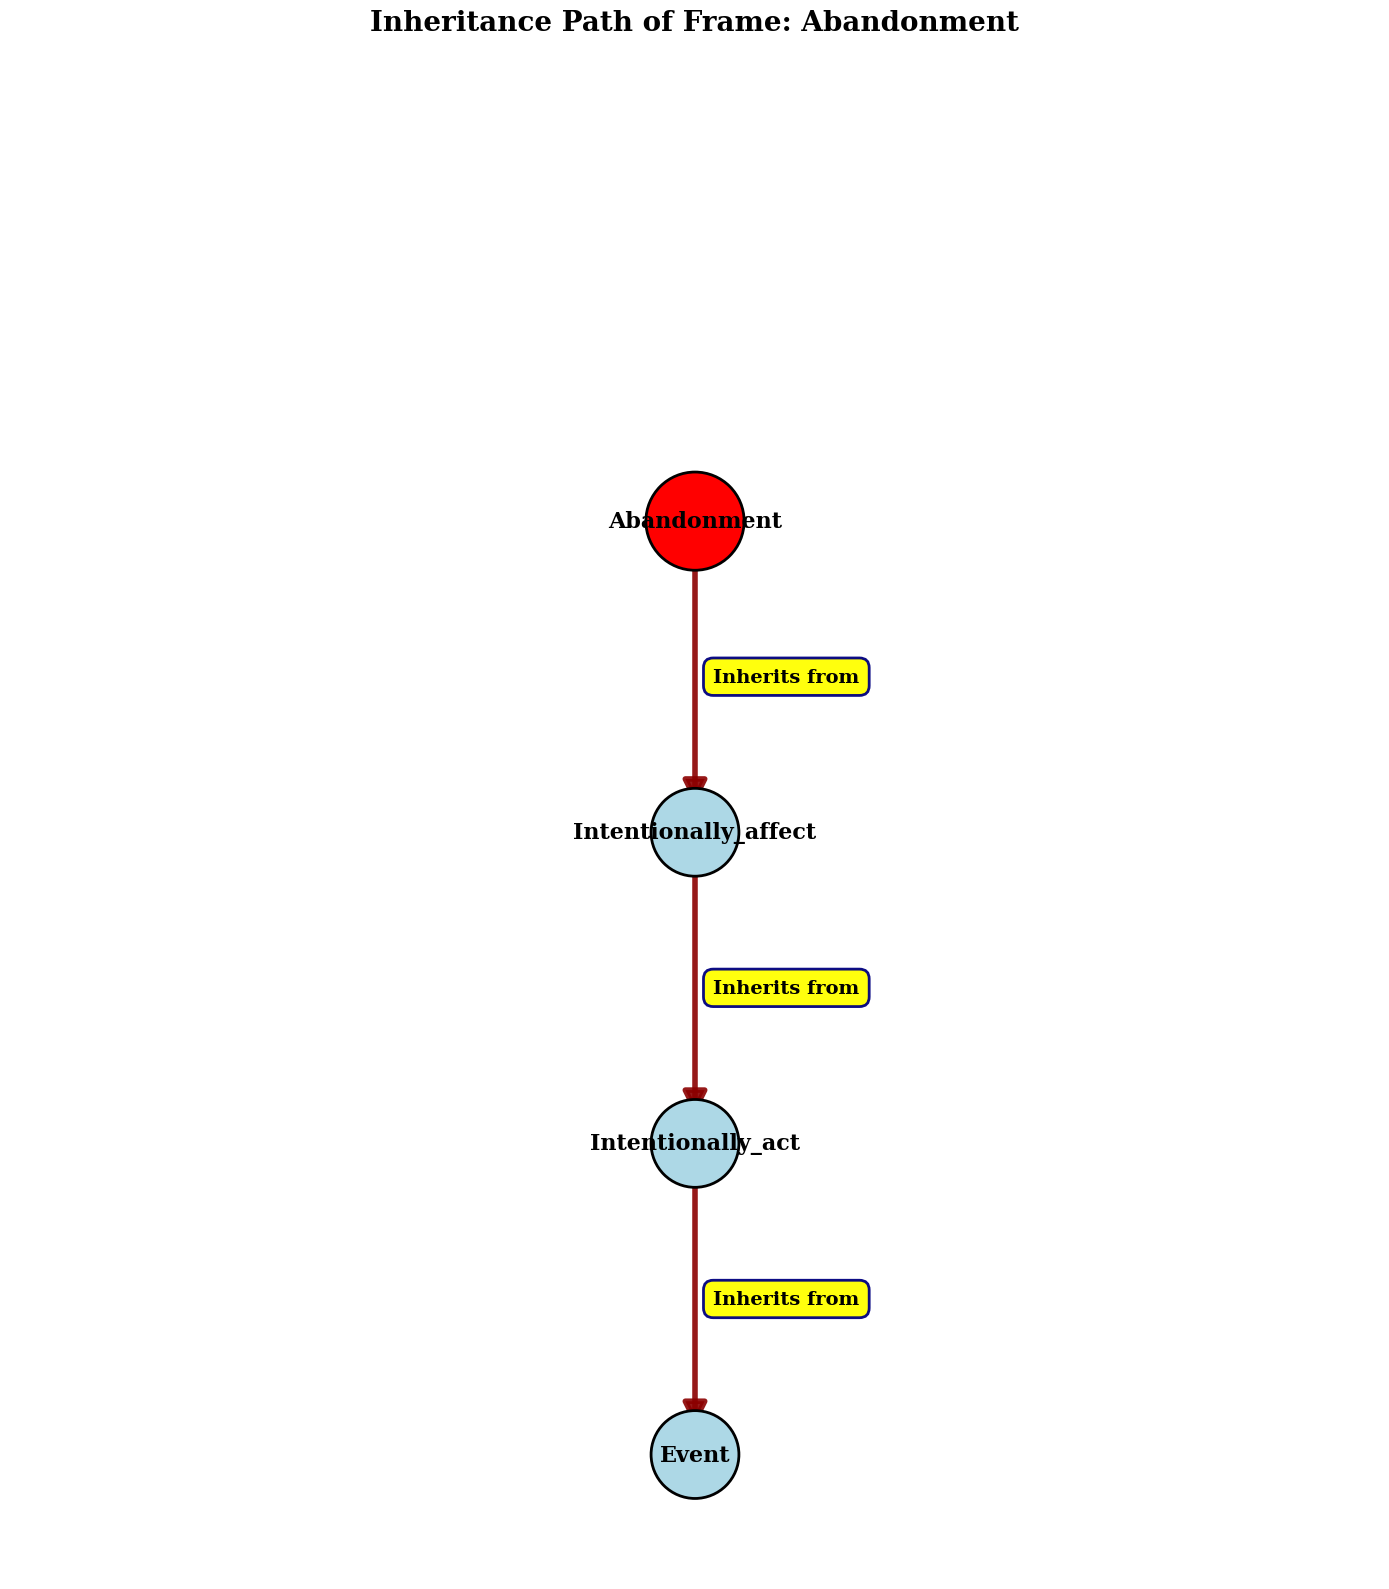

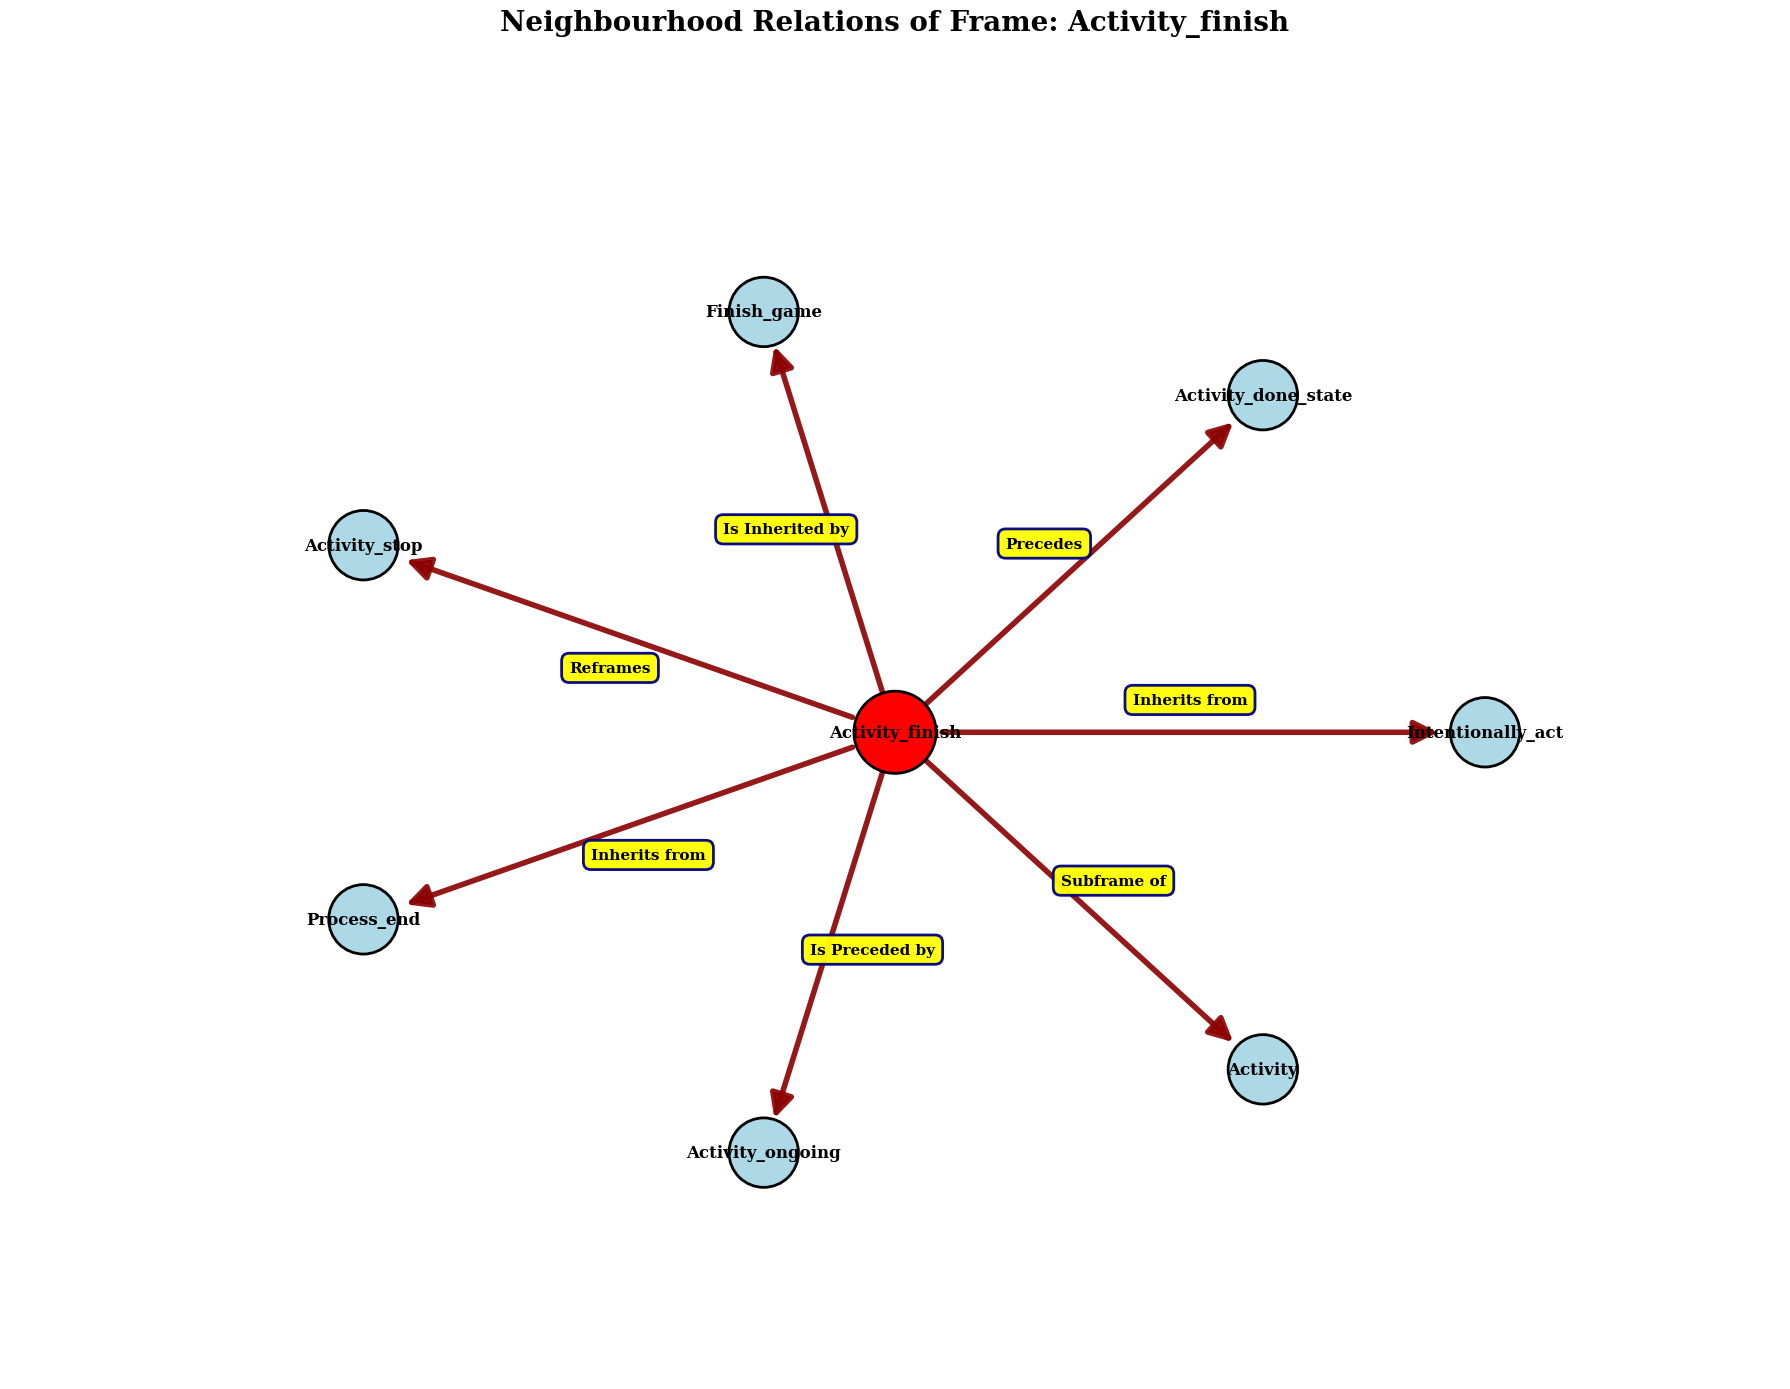

In [ ]:
# @title 🔍 Visualise FrameNet Data Structures

# Set font for better appearance (Colab compatible)
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.size'] = 10

def visualize_frame_structure(frame_relations, target_frame, mode="neighbourhood", layout='spring', title=None, save_path=None):
    """
    Visualize frame semantic structure using extracted FrameNet data.
    """

    if target_frame not in frame_relations:
        print(f"[ERROR] Frame not found: {target_frame}")
        return

    if mode == "upward":
        if not title:
            title = f"Inheritance Path of Frame: {target_frame}"

        # Find inheritance path by following inheritance relations
        path = [target_frame]
        current = target_frame
        visited = {current}

        while True:
            parent_found = False
            relations = frame_relations.get(current, [])

            for neighbor, rel_type, direction, edge_label in relations:
                if neighbor in visited:
                    continue
                # Look for inheritance where current frame inherits from neighbor
                if rel_type == "Inheritance" and direction == "in":
                    path.insert(0, neighbor)  # Add parent at beginning
                    current = neighbor
                    visited.add(current)
                    parent_found = True
                    break

            if not parent_found:
                break

        # Create inheritance subgraph
        subgraph = nx.DiGraph()
        if len(path) == 1:
            subgraph.add_node(target_frame)
            print(f"[INFO] No inheritance path found for {target_frame}")
        else:
            for i in range(len(path) - 1):
                parent = path[i]
                child = path[i + 1]
                # Arrow from child to parent: child -> parent "Inherits from"
                subgraph.add_edge(child, parent, relation="Inherits from")

    elif mode == "neighbourhood":
        if not title:
            title = f"Neighbourhood Relations of Frame: {target_frame}"

        # Get all relations for the target frame
        relations = frame_relations.get(target_frame, [])

        # Collect all neighbor frames
        neighbors = set()
        for neighbor, rel_type, direction, edge_label in relations:
            neighbors.add(neighbor)

        # Create subgraph with all arrows FROM target frame
        subgraph = nx.DiGraph()
        subgraph.add_node(target_frame)
        subgraph.add_nodes_from(neighbors)

        # Add edges with labels from RELATION_LABELS
        for neighbor, rel_type, direction, edge_label in relations:
            # Get the appropriate label based on direction
            if rel_type in RELATION_LABELS:
                label_out, label_in = RELATION_LABELS[rel_type]
                if direction == "out":
                    label = label_out  # target gives the relation
                else:  # direction == "in"
                    label = label_in   # target receives the relation
            else:
                label = f"{rel_type} ({direction})"

            # All arrows point FROM target_frame TO neighbors
            subgraph.add_edge(target_frame, neighbor, relation=label)

    else:
        raise ValueError("mode must be 'neighbourhood' or 'upward'")

    if len(subgraph.nodes()) == 0:
        print(f"[ERROR] No nodes found for visualization")
        return

    # Layout calculation
    num_nodes = len(subgraph.nodes())

    if num_nodes == 1:
        pos = {list(subgraph.nodes())[0]: (0, 0)}
    elif mode == "upward":
        # Vertical hierarchical layout for inheritance
        nodes = list(subgraph.nodes())
        if subgraph.edges():
            try:
                ordered_nodes = list(nx.topological_sort(subgraph))
                pos = {}
                level_height = 5.0  # Large spacing
                for i, node in enumerate(ordered_nodes):
                    pos[node] = (0, (len(ordered_nodes) - i - 1) * level_height)
            except:
                pos = {node: (0, i * 5.0) for i, node in enumerate(reversed(nodes))}
        else:
            pos = {nodes[0]: (0, 0)}
    else:
        # Radial layout for neighbourhood - target in center
        pos = {}
        other_nodes = [n for n in subgraph.nodes() if n != target_frame]
        pos[target_frame] = (0, 0)

        if other_nodes:
            angle_step = 2 * np.pi / len(other_nodes)
            radius = 4.0
            for i, node in enumerate(other_nodes):
                angle = i * angle_step
                pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

    # Create figure with large size
    if mode == "upward":
        fig_height = max(16, len(subgraph.nodes()) * 4)
        fig, ax = plt.subplots(1, 1, figsize=(14, fig_height))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(18, 14))

    # Draw nodes
    node_colors = ["red" if n == target_frame else "lightblue" for n in subgraph.nodes()]
    if mode == "upward":
        node_sizes = [5000 if n == target_frame else 4000 for n in subgraph.nodes()]
    else:
        node_sizes = [3500 if n == target_frame else 2500 for n in subgraph.nodes()]

    nx.draw_networkx_nodes(subgraph, pos,
                          node_size=node_sizes,
                          node_color=node_colors,
                          edgecolors='black',
                          linewidths=2,
                          ax=ax)

    # Draw node labels
    label_font_size = 16 if mode == "upward" else 12
    nx.draw_networkx_labels(subgraph, pos,
                           font_size=label_font_size,
                           font_weight="bold",
                           font_family='DejaVu Serif',
                           ax=ax)

    # Draw edges with relation labels
    for u, v, data in subgraph.edges(data=True):
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)

        if length > 0:
            dx_norm = dx / length
            dy_norm = dy / length

            # Adjust arrow positions to avoid node overlap
            node_radius = 0.4 if mode == "upward" else 0.3
            start_x = x1 + dx_norm * node_radius
            start_y = y1 + dy_norm * node_radius
            end_x = x2 - dx_norm * node_radius
            end_y = y2 - dy_norm * node_radius

            # Draw thick, prominent arrow
            arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                   arrowstyle='-|>',
                                   mutation_scale=35,
                                   color='darkred',
                                   linewidth=4,
                                   alpha=0.9)
            ax.add_patch(arrow)

            # Add relation label
            relation = data.get("relation", "")
            if relation:
                # Position label at edge midpoint
                label_x = (start_x + end_x) / 2
                label_y = (start_y + end_y) / 2

                # Offset label perpendicular to edge for readability
                perp_offset = 0.4 if mode == "upward" else 0.3
                perp_x = -dy_norm * perp_offset
                perp_y = dx_norm * perp_offset

                label_font_size = 14 if mode == "upward" else 11
                ax.text(label_x + perp_x, label_y + perp_y, relation,
                       fontsize=label_font_size,
                       ha='center',
                       va='center',
                       weight='bold',
                       family='DejaVu Serif',
                       bbox=dict(boxstyle="round,pad=0.5",
                               facecolor="yellow",
                               alpha=0.95,
                               edgecolor="navy",
                               linewidth=2))

    ax.set_title(title, fontsize=20, fontweight='bold', family='DejaVu Serif', pad=40)
    ax.axis("off")

    # Set axis limits to ensure everything is visible
    if mode == "upward":
        ax.set_xlim(-3, 3)
        ax.set_ylim(-2, len(subgraph.nodes()) * 5 + 2)
    else:
        ax.set_xlim(-6, 6)
        ax.set_ylim(-6, 6)

    plt.tight_layout()
    if save_path:
         plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


visualize_frame_structure(frame_relations, "Abandonment", mode="upward", save_path="abandonment_inheritance.png")
visualize_frame_structure(frame_relations, "Activity_finish", mode="neighbourhood", save_path="activity_finish_neighbourhood.png")

In [ ]:
# @title 📦 Construct and Analyse Frame Graph

def build_frame_graph(frame_relations):

    """
    Build the semantic frame graph using all FrameNet relation types.

    Args:
        frame_relations (dict): Mapping from a frame to a list of
                                (related_frame, relation_type, direction, edge_label) tuples.

    Returns:
        frame_graph (MultiDiGraph): A directed multi-relation graph of frame relationships.
        relation_levels (dict): Mapping from frame name to structural level (based on all relation types).
    """
    import networkx as nx
    from collections import deque

    frame_graph = nx.MultiDiGraph()

    # Add nodes and edges
    for frame, relations in frame_relations.items():
        for related_frame, rel_type, direction, edge_label in relations:
            if direction == "out":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
            elif direction == "in":
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)
            elif direction == "undirected":
                frame_graph.add_edge(frame, related_frame, relation=rel_type, label=edge_label)
                frame_graph.add_edge(related_frame, frame, relation=rel_type, label=edge_label)

    # Identify root nodes (no incoming edges of any kind)
    roots = [node for node in frame_graph.nodes() if frame_graph.in_degree(node) == 0]

    # Compute relation levels from all roots, using all relation types
    relation_levels = {}
    for root in roots:
        queue = deque([(root, 0)])
        visited = set([root])

        while queue:
            node, level = queue.popleft()
            if node in relation_levels:
                relation_levels[node] = min(relation_levels[node], level)
            else:
                relation_levels[node] = level

            for _, child, data in frame_graph.out_edges(node, data=True):
                if child not in visited:
                    visited.add(child)
                    queue.append((child, level + 1))

    # Assign -1 to nodes not reachable from any root
    for node in frame_graph.nodes():
        if node not in relation_levels:
            relation_levels[node] = -1

    return frame_graph, relation_levels


# Load previously saved data
print("Loading FrameNet data...")
try:
    with open("framenet_data.pkl", 'rb') as f:
        data = pickle.load(f)

    frame_relations = data['frame_relations']
    frame_definitions = data['frame_definitions']
    df = data['dataframe']

    print(f"Successfully loaded data: {len(frame_relations)} frame relations, {len(frame_definitions)} frame definitions")
except FileNotFoundError:
    print("Data file not found. Please run the data extraction script first.")
    import sys
    sys.exit(1)

# Build the frame graph and compute structure levels
print("\nBuilding full semantic relation graph...")
frame_graph, relation_levels = build_frame_graph(frame_relations)

# Basic graph statistics
print(f"The graph contains {frame_graph.number_of_nodes()} nodes and {frame_graph.number_of_edges()} edges")

# Analyse structural levels (depths from root using all relations)
print("\nAnalysing frame structure levels (based on all relation types)...")
level_counts = defaultdict(int)
for frame, level in relation_levels.items():
    level_counts[level] += 1

print("Number of frames per level:")
for level in sorted(level_counts.keys()):
    if level >= 0:
        print(f"  Level {level}: {level_counts[level]} frames")
print(f"  Unreachable (level = -1): {level_counts[-1]} frames")

# Identify root nodes (frames with no incoming edges)
roots = [n for n in frame_graph.nodes() if frame_graph.in_degree(n) == 0]
if roots:
    print(f"\nFound {len(roots)} root nodes (frames with no incoming edges):")
    for i, root in enumerate(sorted(roots)[:10]):
        print(f"  {i+1}. {root}")
    if len(roots) > 10:
        print(f"  ...and {len(roots)-10} more")

    # Compute the largest reachable subgraph from any root
    max_subtree_size = 0
    max_root = None
    for root in roots:
        queue = [root]
        visited = set([root])
        while queue:
            node = queue.pop(0)
            for successor in frame_graph.successors(node):
                if successor not in visited:
                    visited.add(successor)
                    queue.append(successor)
        if len(visited) > max_subtree_size:
            max_subtree_size = len(visited)
            max_root = root

    print(f"\nRoot of the largest reachable subgraph: '{max_root}' with {max_subtree_size} frames")

# Extra: print statistics about frame relation distribution
print("\nAnalysing relation density per frame...")
outgoing_counts = defaultdict(int)
incoming_counts = defaultdict(int)
relation_type_counter = defaultdict(int)

for u, v, data in frame_graph.edges(data=True):
    outgoing_counts[u] += 1
    incoming_counts[v] += 1
    relation_type_counter[data['relation']] += 1

total_frames = frame_graph.number_of_nodes()
no_outgoing = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0]
no_incoming = [f for f in frame_graph.nodes() if incoming_counts[f] == 0]
no_edges = [f for f in frame_graph.nodes() if outgoing_counts[f] == 0 and incoming_counts[f] == 0]

print(f"Frames with no outgoing relations: {len(no_outgoing)}")
print(f"Frames with no incoming relations: {len(no_incoming)}")
print(f"Completely isolated frames (no relations at all): {len(no_edges)}")

# Print most relationally dense frames
dense_out = sorted(outgoing_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 frames by number of outgoing relations:")
for f, count in dense_out:
    print(f"  {f}: {count} outgoing")

# Print relation type frequency
print("\nRelation type distribution:")
for rel, count in sorted(relation_type_counter.items(), key=lambda x: -x[1]):
    print(f"  {rel}: {count} edges")

# Save graph and relation-level info
frame_graph_data = {
    'graph': frame_graph,
    'levels': relation_levels,
    'level_stats': dict(level_counts),
    'roots': roots
}
with open('frame_graph_analysis.pkl', 'wb') as f:
    pickle.dump(frame_graph_data, f)
print("\nGraph structure data saved to frame_graph_analysis.pkl")

# Analyse graph connectivity
print("\nAnalysing graph connectivity...")
connected_components = list(nx.weakly_connected_components(frame_graph))
largest_cc = max(connected_components, key=len)
print(f"Largest weakly connected component contains {len(largest_cc)} nodes "
      f"({len(largest_cc)/frame_graph.number_of_nodes():.1%} of total)")

# Compute graph diameter of largest component (undirected)
print("\nComputing diameter of largest connected component...")
try:
    largest_cc_subgraph = frame_graph.subgraph(largest_cc)
    diameter = nx.diameter(nx.Graph(largest_cc_subgraph))
    print(f"Diameter of the largest component: {diameter}")
except Exception as e:
    print(f"Error computing diameter: {e}")

print("\nFull frame graph analysis complete!")
